In [1]:
from google.colab import drive
drive.mount('/content/drive')

outdir = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/'

import librosa 


import IPython

import IPython.display as ipd
from IPython.display import Audio

print('Without preprocessing')
IPython.display.display( Audio(signal3,rate=sr3,autoplay=False ))       

Mounted at /content/drive


In [ ]:
if 0:
  sr=4000

  for name in [filenames[111]]:   
      file = root + name + '.wav'
      signal, sr = lr.load(file, sr=sr) #  

  #z = librosa.feature.spectral_centroid(signal, sr=sr)[0]
  z2 = librosa.feature.spectral_centroid(signal, sr=sr)[0]
  z3 = librosa.feature.spectral_centroid(signal, sr=sr)[0]

  print( z.shape, z2.shape, z3.shape )

  s_centroid= np.zeros( (len(filenames), audio_length ) )
  s_centroid[ 0, : ] = z
  s_centroid[ 1, :len(z2) ] = z2

  outdir = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/'

  spio.savemat( outdir + 's_centroid.mat', {'s_centroid': s_centroid } ) 


  test= np.random.random( (len(filenames), 15171) )
  spio.savemat( outdir + 'big.mat', {'test': test } ) 

# 920

len(filenames) 


690

22050

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd

# Not immediately usable with this dataset as files contain 24-bit data
from scipy.io import wavfile
from scipy.io.wavfile import read, write

import IPython.display as ipd
from IPython.display import Audio
from numpy.fft import fft, ifft
from glob import glob
import librosa as lr
import librosa.display
import os
import pickle
from scipy import signal as sig
from scipy.signal import butter, lfilter
from tqdm import tqdm
import pywt
import random
import skimage.data
from skimage.restoration import denoise_wavelet
import pywt
from pywt import swt
import time as tm

if ('pydub' in globals()) == False:
  !pip install pydub
from pydub import AudioSegment
# from pydub.utils import make_chunks


# LT-06-24: import io to save intermediate outputs; use "as" to shorten module.function name as "spio"
import scipy.io as spio


# LT-06-24: install modules if not found 
if ( 'umap' in globals() ) == False: 
  !pip install umap-learn
  !pip install tsmoothie

import umap.umap_ as umap

# from tsmoothie.smoother import LowessSmoother

import sklearn
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

     |████████████████████████████████| 80 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 18.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=a9b2a88824f546a2c4d3604f01f32ecffb39cfe0e78266ae8fab5d6a322023ce
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=5d1ac80907e0d235f827b5f0eadc2ab0c28f8282fc4f59d3bbf3ef17ec8c7f94
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [ ]:
root = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

# Extract text filenames
textnames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

# Extract audio filenames
audionames = [s.split('.')[0] for s in os.listdir(path = root) if '.wav' in s]

len(audionames)

920

In [ ]:
train_data = audionames[:690]
filenames = sorted(train_data)
test_data = audionames[690:]

In [ ]:
diag_df = pd.read_csv('/content/drive/MyDrive/ICBHI/ICBHI_Challenge_diagnosis.txt', 
                      delimiter='\t',
                      names=['Subject ID', 'Diagnosis'], 
                      header=None)

# Extract file information and annotation information
def extract_file(filename, root):
    tokens = filename.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Subject ID', 'Recording Index', 'Chest Location','Acquisition Mode','Recording Equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, filename + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

# Information about each file, annotations from each file
information = []
annotations = []
for file in textnames:
    (info, anno) = extract_file(file, root)
    information.append(info)
    name_data = file.split('_')
    anno['Subject ID'] = name_data[0]
    anno['Chest Location'] = name_data[2]
    anno['Mode'] = name_data[3]
    anno['Equipment'] = name_data[4]
    anno['Filename'] = file
    annotations.append(anno)

anno_df = pd.concat(annotations, ignore_index=True)

# Merge diag_df with anno_df on Subject ID
diag_df['Subject ID'] = diag_df['Subject ID'].astype('int32')
anno_df['Subject ID'] = anno_df['Subject ID'].astype('int32')
sub_anno_df = pd.merge(diag_df, anno_df, on='Subject ID')
sub_anno_df.head()

,Subject ID,Diagnosis,Start,End,Crackles,Wheezes,Chest Location,Mode,Equipment,Filename
0,101,URTI,0.036,0.579,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
1,101,URTI,0.579,2.450,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
2,101,URTI,2.450,3.893,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
3,101,URTI,3.893,5.793,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron
4,101,URTI,5.793,7.521,0,0,Al,sc,Meditron,101_1b1_Al_sc_Meditron


In [ ]:
no_label = []
crackles_only = []
wheezes_only = []
both_symp = []
for file in filenames:
    data = anno_df.loc[anno_df['Filename'] == file]
    no_labels = len(data[(data['Crackles'] == 0) & (data['Wheezes'] == 0)].index)
    crackles = len(data[(data['Crackles'] == 1) & (data['Wheezes'] == 0)].index)
    wheezes = len(data[(data['Crackles'] == 0) & (data['Wheezes'] == 1)].index)
    both_symps = len(data[(data['Crackles'] == 1) & (data['Wheezes'] == 1)].index)
    no_label.append(no_labels)
    crackles_only.append(crackles)
    wheezes_only.append(wheezes)
    both_symp.append(both_symps)

label_df = pd.DataFrame(data = {'Filename':filenames, 'No Label':no_label, 'Crackles Only':crackles_only, 'Wheezes Only':wheezes_only, 'Crackles and Wheezes':both_symp})
label_df.head()

,Filename,No Label,Crackles Only,Wheezes Only,Crackles and Wheezes
0,101_1b1_Al_sc_Meditron,12,0,0,0
1,101_1b1_Pr_sc_Meditron,11,0,0,0
2,102_1b1_Ar_sc_Meditron,13,0,0,0
3,103_2b2_Ar_mc_LittC2SE,2,0,4,0
4,104_1b1_Al_sc_Litt3200,6,0,0,0


In [ ]:
# Get waveforms
def signal_and_sr(filename, root):
    name = root + filename + '.wav'
    data, sr = lr.load(name, sr=4000) # Sampling rate at 4000Hz according to Roche et al., also standard for Eko Duo (typical for librosa but dataset contains more than one sr - 44100, 4000 and 10000)
    return (data, sr)

def waveform(filenames):
  """
  downsamples the filenames before they are converted to waveforms as a dictionary
  """
  waveforms = {}
  for name in filenames[::100]:
    (signal, sr) = signal_and_sr(name, root) # signal is an array with (sr * duration) values, sr is 4000
    if (len(signal) % 2) == 0: # signal array must be an even number of values for MODWT
      waveforms[name] = signal

  return waveforms

In [ ]:
os.mkdir('obj')

def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:

outdir = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/'
# spio.savemat( outdir + 'test.mat', {'test': 1 }) 


In [ ]:

outdir = '/content/drive/MyDrive/ICBHI/Respiratory_Sound_Database/'

if (('train_waves.pkl' in os.listdir('obj')) == False):
  train_waves = waveform(train_data)
  save_obj(train_waves, outdir + 'train_waves')
else:
  train_waves = load_obj('train_waves')

In [ ]:
if (('test_waves.pkl' in os.listdir('obj')) == False):
  test_waves = waveform(test_data)
  save_obj(train_waves, 'test_waves')
else:
  test_waves = load_obj('test_waves')

In [ ]:

# not sure if this is the best state to save, but doing to illustrate
#
# LT: exercise for you: load saved mat file to access the data; hint: dat['train_waves']
#
if (('waveforms.mat' in os.listdir()) == False):
  train_waves = waveform(train_data)
  test_waves = waveform(test_data)
  spio.savemat( 'waveforms.mat', { 'train_waves': train_waves, 'test_waves': test_waves }  )
else:
  dat = spio.loadmat( 'waveforms.mat' )
  train_waves = dat['train_waves']
  test_waves = dat['test_waves']

In [ ]:
for filename, signal in train_waves.items():
  print(len(signal))

80000
80000
80000
80000
80000
80000
44992


In [ ]:
len(train_waves.values())

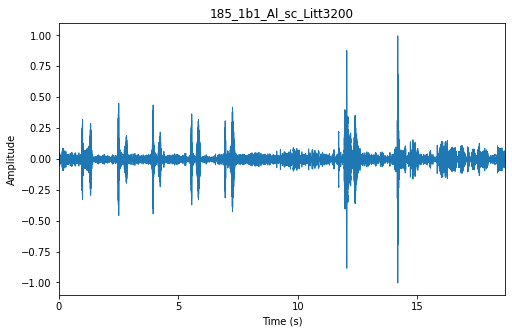

In [ ]:
plt.figure(figsize=(8,5))
lr.display.waveplot(train_waves['185_1b1_Al_sc_Litt3200'], sr=4000)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('185_1b1_Al_sc_Litt3200')
plt.show()

In [ ]:
Audio(root + '185_1b1_Al_sc_Litt3200' + '.wav')

In [ ]:
sub_anno_df.loc[sub_anno_df['Filename'] == '185_1b1_Al_sc_Litt3200']

,Subject ID,Diagnosis,Start,End,Crackles,Wheezes,Chest Location,Mode,Equipment,Filename
4823,185,COPD,0.31321,1.6082,0,0,Al,sc,Litt3200,185_1b1_Al_sc_Litt3200
4824,185,COPD,1.60820,3.0779,0,0,Al,sc,Litt3200,185_1b1_Al_sc_Litt3200
4825,185,COPD,3.07790,4.4331,0,0,Al,sc,Litt3200,185_1b1_Al_sc_Litt3200
4826,185,COPD,4.43310,6.0533,0,0,Al,sc,Litt3200,185_1b1_Al_sc_Litt3200
4827,185,COPD,6.05330,9.1372,0,0,Al,sc,Litt3200,185_1b1_Al_sc_Litt3200
4828,185,COPD,9.13720,15.1480,0,0,Al,sc,Litt3200,185_1b1_Al_sc_Litt3200
4829,185,COPD,15.14800,18.6720,0,0,Al,sc,Litt3200,185_1b1_Al_sc_Litt3200


Zero-Crossing Rate

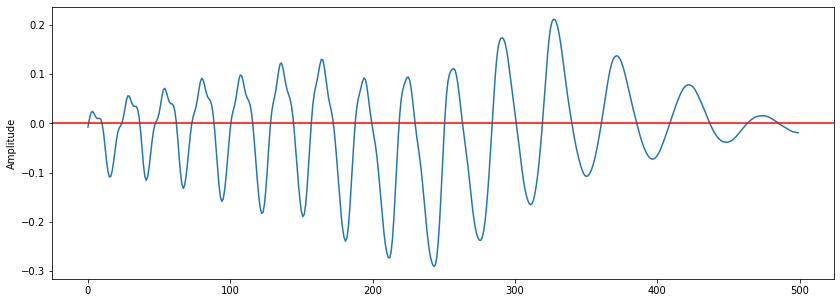

In [ ]:
plt.figure(figsize=(14,5))
plt.ylabel('Amplitude')
plt.plot(train_waves['185_1b1_Al_sc_Litt3200'][5000:5500])
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Spectrogram

In [ ]:
def spec_stft(wave_dict):
  """
  converts signal to STFT to determine the amplitude of frequencies at a given time;
  loudness of a signal over time at various frequencies
  """
  spec_dict = {}
  for filename, signal in wave_dict.items():
    stft = librosa.stft(signal)
    spec_dict[filename] = librosa.amplitude_to_db(abs(stft))
  return spec_dict

In [ ]:
if ('stft_spec.mat' in os.listdir()) == False:
  train_spec = spec_stft(train_waves)
  test_spec = spec_stft(test_waves)
  spio.savemat( 'stft_spec.mat', { 'train_waves': train_spec, 'test_spec': test_spec }  )
else:
  spio.loadmat('stft_spec.mat')

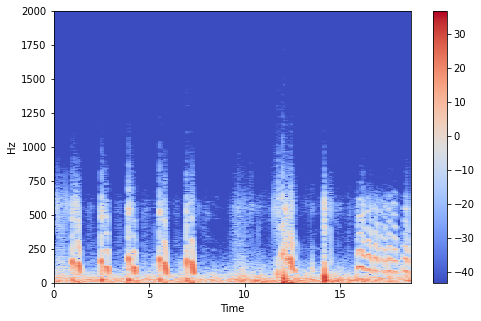

In [ ]:
# Frequency Axis
plt.figure(figsize=(8,5))
librosa.display.specshow(train_spec['185_1b1_Al_sc_Litt3200'], sr=4000, x_axis='time', y_axis='hz')
plt.colorbar();

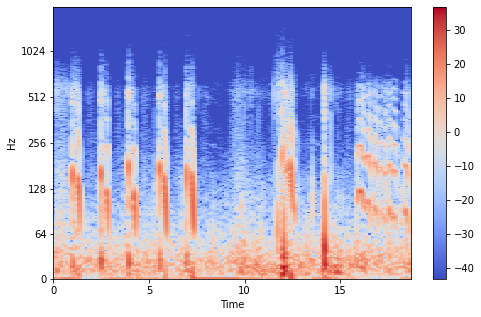

In [ ]:
# Logarithmic Axis; shifts activity up so it is more visible
plt.figure(figsize=(8,5))
librosa.display.specshow(train_spec['185_1b1_Al_sc_Litt3200'], sr=4000, x_axis='time', y_axis='log')
plt.colorbar();

Mel-Frequency Cepstral Coefficients

In [ ]:
def mel_freq_cc(wave_dict):
  """
  extracts the timbral information (spectral envelope) of signals in wave_dict
  """
  mfccs = {}
  for filename, signal in wave_dict.items():
    mfccs[filename] = librosa.feature.mfcc(y=signal, sr=4000)
  return mfccs

In [ ]:
if ('mfccs.mat' in os.listdir()) == False:
  train_mfccs = mel_freq_cc(train_waves)
  test_mfccs = mel_freq_cc(test_waves)
  spio.savemat( 'mfccs.mat', { 'train_mfccs': train_mfccs, 'test_mfccs': test_mfccs }  )
else:
  dat= spio.loadmat( 'mfccs.mat' )


In [ ]:
# Number of MFFCs calculated (rows), number of frames
print(train_mfccs['185_1b1_Al_sc_Litt3200'].shape)

(20, 146)


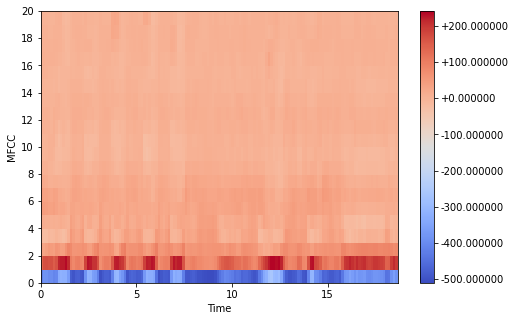

In [ ]:
# Y: coefficients
plt.figure(figsize=(8,5))
librosa.display.specshow(train_mfccs['185_1b1_Al_sc_Litt3200'], sr=4000, x_axis='time')
plt.ylabel('MFCC')
plt.yticks(np.arange(0,21, step=2))
plt.colorbar(format="%+2f");

Spectral Centroid

In [ ]:
def spec_centroid(wave_dict):
  """
  determines which frequency the energy of a spectrum is centered upon; center of
  mass for a sound

  second dimension is the values of spectral centroid across time
  """
  centroid_dict = {}
  for filename, signal in wave_dict.items():
    centroid_dict[filename] = librosa.feature.spectral_centroid(signal, sr=4000, n_fft=512, hop_length=256)[0]
  return centroid_dict

In [ ]:
# Cannot be visualized through matplotlib as dictionary values are diff shapes

if ('centroids.mat' in os.listdir()) == False:
  train_centroid = spec_centroid(train_waves)
  test_centroid = spec_centroid(test_waves)
  spio.savemat( 'centroids.mat', { 'train_centroid': train_centroid, 'test_centroid': test_centroid }  )
else:
  dat= spio.loadmat( 'centroids.mat' )


In [ ]:
def for_spec_cen_graph(wave_dict):
  centroids = []
  for filename, signal in wave_dict.items():
    centroids.append(librosa.feature.spectral_centroid(signal, sr=4000, n_fft=512, hop_length=256)[0])
  return np.array(centroids, dtype=object)

In [ ]:
if ('cen_graph.mat' in os.listdir()) == False:
  train_cen_graph = for_spec_cen_graph(train_waves)
  test_cen_graph = for_spec_cen_graph(test_waves)
  spio.savemat( 'cen_graph.mat', {'train_cen_graph':train_cen_graph, 'test_cen_graph': test_cen_graph } )
else:
  dat= spio.loadmat( 'cen_graph.mat' )


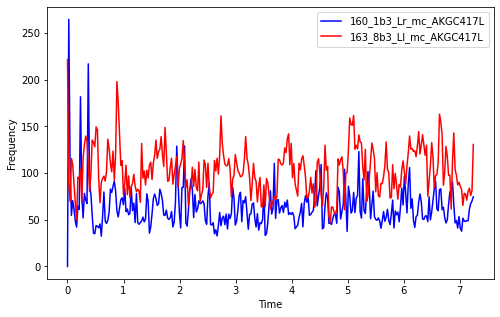

In [ ]:
plt.figure(figsize=(8,5))
frames = range(len(train_cen_graph[0]))
time = librosa.frames_to_time(frames)

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.plot(time, train_cen_graph[0], color='b', label=str(list(train_centroid.keys())[0]))
plt.plot(time, train_cen_graph[50], color='r', label=str(list(train_centroid.keys())[50]))
plt.legend(loc='upper right')
plt.show()

In [ ]:
print(sub_anno_df.loc[sub_anno_df['Filename'] == '160_1b3_Lr_mc_AKGC417L']['Diagnosis'])
print(sub_anno_df.loc[sub_anno_df['Filename'] == '163_8b3_Ll_mc_AKGC417L']['Diagnosis'])

3349    COPD
3350    COPD
3351    COPD
3352    COPD
3353    COPD
Name: Diagnosis, dtype: object
3605    COPD
3606    COPD
3607    COPD
3608    COPD
3609    COPD
3610    COPD
Name: Diagnosis, dtype: object


In [ ]:
Audio(root + '160_1b3_Lr_mc_AKGC417L' + '.wav')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio(root + '163_8b3_Ll_mc_AKGC417L' + '.wav')

Output hidden; open in https://colab.research.google.com to view.

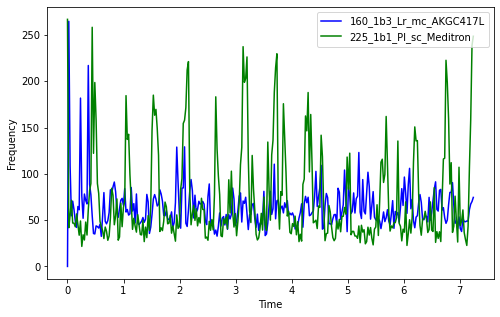

In [ ]:
plt.figure(figsize=(8,5))
frames = range(len(train_cen_graph[0]))
time = librosa.frames_to_time(frames)

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.plot(time, train_cen_graph[0], color='b', label=str(list(train_centroid.keys())[0]))
plt.plot(time, train_cen_graph[482], color='g', label=str(list(train_centroid.keys())[482]))
plt.legend(loc='upper right')
plt.show()

In [ ]:
print(sub_anno_df.loc[sub_anno_df['Filename'] == '160_1b3_Lr_mc_AKGC417L']['Diagnosis'])
print(sub_anno_df.loc[sub_anno_df['Filename'] == '225_1b1_Pl_sc_Meditron']['Diagnosis'])

3349    COPD
3350    COPD
3351    COPD
3352    COPD
3353    COPD
Name: Diagnosis, dtype: object
6853    Healthy
6854    Healthy
6855    Healthy
6856    Healthy
6857    Healthy
6858    Healthy
6859    Healthy
6860    Healthy
6861    Healthy
6862    Healthy
6863    Healthy
6864    Healthy
6865    Healthy
6866    Healthy
Name: Diagnosis, dtype: object


In [ ]:
Audio(root + '225_1b1_Pl_sc_Meditron' + '.wav')

Output hidden; open in https://colab.research.google.com to view.

Butterworth Bandpass

In [ ]:
def butter_bandpass(lowcut, highcut, fs=4000, order=12):
  nyq = 0.5 * fs
  low = lowcut / nyq
  high = highcut / nyq
  b, a = butter(order, [low, high], btype='band')
  return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs=4000, order=12):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = lfilter(b, a, data)
  return np.array(y)

def butter_bandpass_dict(wave_dict, lowcut, highcut):
  """
  takes a waveform dictionary and applies a butterworth bandpass filter to each file
  """
  bp_dict = {}
  for filename, signal in wave_dict.items():
    bp_dict[filename] = butter_bandpass_filter(signal, lowcut, highcut)
  return bp_dict

In [ ]:
MFCCs = np.zeros( (10, 20, 200 ) );

for  i,k in enumerate(train_waves.keys() ) :
  signal=train_waves[k]


  #print( signal.shape )

  m=butter_bandpass_filter(signal, 120, 1800)
  print( k, m.shape[0]/sr )

  mfccs = librosa.feature.mfcc(y=m, sr=4000)
  print(mfccs.shape)

  a,b=mfccs.shape
  MFCCs[i, :a, :b] = mfccs 



160_1b3_Lr_mc_AKGC417L 20.0
(20, 157)
172_1b3_Tc_mc_AKGC417L 20.0
(20, 157)
178_1b3_Tc_mc_AKGC417L 20.0
(20, 157)
198_1b5_Ar_mc_AKGC417L 20.0
(20, 157)
207_2b2_Pr_mc_AKGC417L 20.0
(20, 157)
101_1b1_Al_sc_Meditron 20.0
(20, 157)
124_1b1_Ar_sc_Litt3200 11.248
(20, 88)


In [ ]:
MFCCs.reshape( (10, 20*200) ).shape

(10, 4000)

In [ ]:
if ('bbp_waves.mat' in os.listdir()) == False:
 train_bp_waves = butter_bandpass_dict(train_waves, 120, 1800)
 
 #test_bp_waves = butter_bandpass_dict(test_waves, 120, 1800)
 #spio.savemat('bbp_waves.mat', { 'train_bp_waves': train_bp_waves, 'test_bp_waves': test_bp_waves})

train_bp_waves.values() 




dict_values([array([0.        , 0.        , 0.        , ..., 0.02179027, 0.0228015 ,
       0.02303888])])

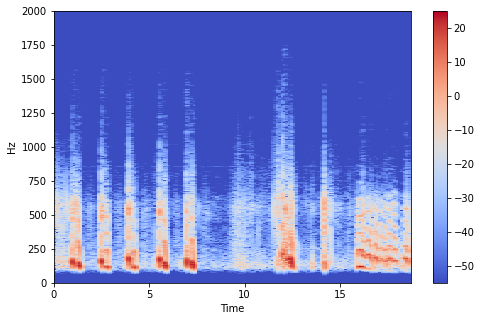

In [ ]:
# Spectrograms with BWBPF applied
train_bp_spec = spec_stft(train_bp_waves)
test_bp_spec = spec_stft(test_bp_waves)

plt.figure(figsize=(8,5))
librosa.display.specshow(train_bp_spec['185_1b1_Al_sc_Litt3200'], cmap='coolwarm', sr=4000, x_axis='time', y_axis='hz')
plt.colorbar();

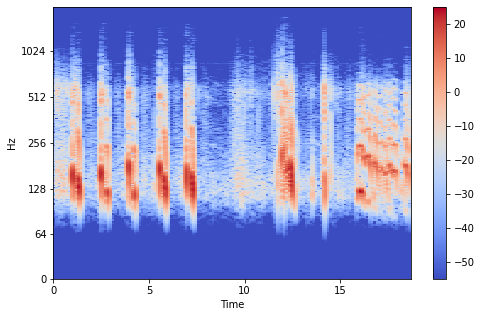

In [ ]:
plt.figure(figsize=(8,5))
librosa.display.specshow(train_bp_spec['185_1b1_Al_sc_Litt3200'], cmap='coolwarm', sr=4000, x_axis='time', y_axis='log')
plt.colorbar();

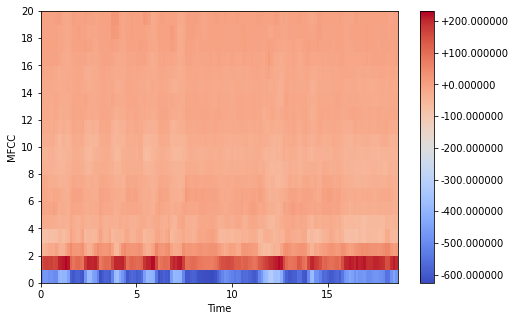

In [ ]:
train_bp_mfcc = mel_freq_cc(train_bp_waves)
test_bp_mfcc = mel_freq_cc(test_bp_waves)

# Y: coefficients
plt.figure(figsize=(8,5))
librosa.display.specshow(train_bp_mfcc['185_1b1_Al_sc_Litt3200'], sr=4000, x_axis='time')
plt.ylabel('MFCC')
plt.yticks(np.arange(0,21, step=2))
plt.colorbar(format="%+2f");

Wavelet Transform

In [ ]:
def wavelet_denoise(wave_dict, wavelet_type):
  """
  takes a noisy wave dict and returns the denoised signals in a new dict
  wavelet_type can by any of pywt.wavelist
  """
  new_waves = {}
  for filename, signal in wave_dict.items():
    new_waves[filename] = denoise_wavelet(signal, wavelet=wavelet_type, mode='soft', wavelet_levels=4, method='BayesShrink', rescale_sigma='True')
  return new_waves

In [ ]:
train_dn_waves = wavelet_denoise(train_waves, 'db5')
test_dn_waves = wavelet_denoise(test_waves, 'db5')

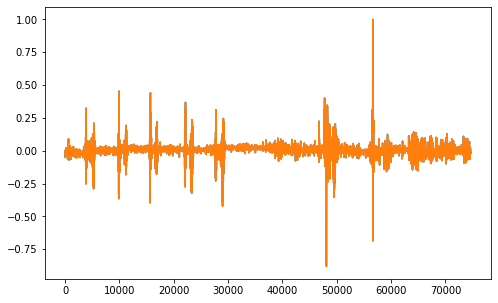

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(train_waves['185_1b1_Al_sc_Litt3200'])
plt.plot(train_dn_waves['185_1b1_Al_sc_Litt3200']);

In [ ]:
def modwt(dn_wd, level):
  """
  takes a dict of denoised wavelets and performs multiple-overlap 1D stationary
  wavelet transform (translation-invariance modification of DWT) on each signal
  
  Fraiwan et al. perform a soft MODWT of level 4, but the array data after denoising
  (non-LOWESS) is not long enough so level 1 is selected

  Butterworth bandpass filtering allowed level to be set at 3.

  Output: list of approximation (index 0) & detail (index 1) coefficients
  """
  modwts = {}
  for filename, signal in dn_wd.items():
    modwts[filename] = pywt.swt(signal, 'db5', level=level, trim_approx=True, norm=True)
  return modwts

In [ ]:
train_modwt = modwt(train_dn_waves, 1)
test_modwt = modwt(test_dn_waves, 1)

In [ ]:
train_bp_modwt = modwt(train_bp_waves, 3)
test_bp_modwt = modwt(test_bp_waves, 3)

Displacement Artifact Removal (LOESS)

In [ ]:
def lowess(wave_dict):
  """
  takes a noisy wave dict and returns a denoised array (variation of denoise_wavelet)
  """
  lowess_waves = {}
  for filename, signal in wave_dict.items():
    smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
    lowess_waves[filename] = smoother.smooth(signal)
  return lowess_waves

In [ ]:
# This causes the session to crash...
# train_lowess = lowess(train_waves)
# test_lowess = lowess(test_waves)

In [ ]:
# train_lowess_modwt = modwt(train_lowess)
# test_lowess_modwt = modwt(test_lowess)

Z-Score Normalization

In [ ]:
def score(modwt_dict):
  """
  takes a dict of MODWT and z-score normalizes each signal, stored in a new dict
  
  not used for clustering
  """
  normal_dict = {}
  for filename, signal in modwt_dict.items():
    scaler = StandardScaler()
    normal_dict[filename] = scaler.fit_transform(signal)
  return normal_dict

In [ ]:
train_normalized = score(train_bp_modwt)
test_normalized = score(test_bp_modwt)

*Feature* Extraction

In [ ]:
# Extract features
def extract(filenames, root, sr):
  """
  filenames: the names of audio (.wav) files (i.e. 185_1b1_Al_sc_Litt3200)
  root: main directory path
  sr: sample rate
  """
  waveforms = []
  bbfs = [] # Butterworth Bandpass Filter
  spectrograms = []
  centroids = []
  mfccs = []
  modwts = []
  # scores = []


  # Convert .wav files
  for name in filenames[::100]:    # <-- I recommend this trick in R/D (uniform sampling so you examine a subset first); also, definitely save intermediate outputs so you don't repeat the waiting step each day ;-) 
    # print(name)                    # <-- try to add more feedback with free printing ;-)
    
    file = root + name + '.wav'
    signal, sr = lr.load(file, sr=sr) # Sampling rate at 4000Hz according to Roche et al., also standard for Eko Duo (typical for librosa but dataset contains more than one sr - 44100, 4000 and 10000)
    if (len(signal) % 2) == 0: # signal array must be an even number of values for MODWT
      # print(name)
      waveforms.append(signal)

  # Apply bandpass filter
  for i,signal in enumerate( waveforms ):
    z = butter_bandpass_filter(signal, 120, 1800) 
    if i==0:
      bbfs = np.zeros( (len(filenames), z.shape[0]) )     
    bbfs[i,:len(z)] = z 
 
  # Get spectrograms
  for i, signal in enumerate( bbfs ):    
    stft = librosa.stft(signal)
    z = librosa.amplitude_to_db(abs(stft))[0] 
    if i==0:
      spectrograms = np.zeros( (len(filenames), z.shape[0]) ) 
    spectrograms[i,:] = z

  # Get centroids
  for i, signal in enumerate(bbfs):
    z = librosa.feature.spectral_centroid(signal, sr=sr)[0]
    if i == 0:
      centroids = np.zeros((len(filenames), z.shape[0]))
    centroids[i,:] = z

  # Get MFCCs
  for i, signal in enumerate(bbfs):
    z = librosa.feature.mfcc(y=signal, sr=sr)[0]
    if i == 0:
      mfccs = np.zeros((len(filenames), z.shape[0]))
    mfccs[i,:] = z
  
  # Get MODWTs
  for i, signal in enumerate(bbfs):
    z = pywt.swt(signal, 'db5', level=3, trim_approx=True, norm=True)[1]
    if i == 0:
      modwts = np.zeros((len(filenames), z.shape[0]))
    modwts[i,:] = z

  return bbfs, spectrograms, centroids, mfccs, modwts

start = tm.time()

if (('features_k5.mat' in os.listdir()) == False): 

  # tip: sorted will help maintatin some degree of orderness so you could leverage the filenaming conventions
  filenames = sorted(train_data)  
  
  # tip: rename variable to convey what it stands will help you especially if you have long break after before you return to your code months later

  bbfs, spectrograms, centroids, mfccs, modwts = extract(filenames, root, 4000)
  features = np.hstack((bbfs, spectrograms))
  features = np.hstack((features, centroids))
  features = np.hstack((features, mfccs))
  features = np.hstack((features, modwts))

  spio.savemat('features_k%d.mat' % features.shape[1], {'features':features} )

  
else:
  dat = spio.loadmat( 'features_k5.mat' )  
  # exercise:
  dat['features'] = features

# task3: timing info would be nice
end = tm.time()
print(f"Runtime to extract is {end-start} s")



In [ ]:
print(bbfs.shape, spectrograms.shape, np.hstack((bbfs, spectrograms)).shape)
features = np.hstack((bbfs, spectrograms))
print(centroids.shape, np.hstack((features, centroids)).shape)
features = np.hstack((features, centroids))
print(mfccs.shape, np.hstack((features, mfccs)).shape)
features = np.hstack((features, mfccs))
print(modwts.shape, np.hstack((features, modwts)).shape)
features = np.hstack((features, modwts))

(690, 80000) (690, 157) (690, 80157)
(690, 157) (690, 80314)
(690, 157) (690, 80471)
(690, 80000) (690, 160471)


UMAP

In [ ]:
# features is 2d array, right? so either features[::SR, : ] or features[:, ::SR] ?  SR=100  
reducer = umap.UMAP(random_state=123)
embedding = reducer.fit_transform(features[:, ::100])

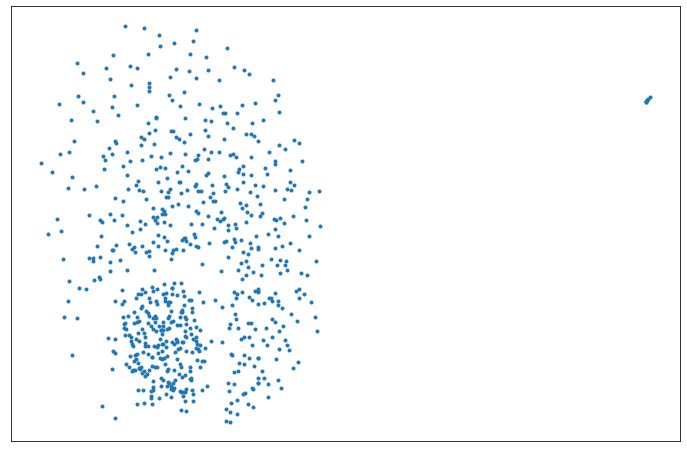

In [ ]:
embedding.shape

fig, ax = plt.subplots(1, figsize=(12,8))
plt.plot( embedding[:,0] , embedding[:,1] ,'.')
plt.xticks([]),plt.yticks([]);

# below is wrong visualization because most samples contain zeros (not all features extracted as well)

# Visualization idea next:
#
# Try to color the embedding as for example: red to represent AKG, blue for Medtronic, etc.:
#
# clrs = ['r', 'g', 'b', 'k']  # one way to remember orderings of color, if you need fewer than 4 colors ;-)
#
# for i, c in enumerate(  ['AKG', ... ] ):   # i love the enumerate function that I don't remember learning in MATLAB ;-) 
#  q = np.where( labels == c ) [0]
#  plt.plot( embedding[q,0] , embedding[q,1] ,'.', colors=clrs[ i ] )


In [ ]:
equipment = []
for name in filenames:
  equipment.append(name.split('_')[4])
equipment = np.array(equipment)

clrs = ['r', 'g', 'b', 'y']

np.unique(equipment)

array(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron'], dtype='<U8')

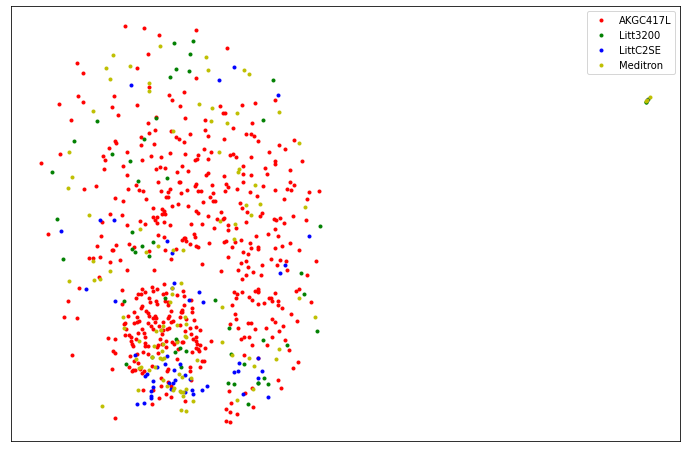

In [ ]:
plt.figure(figsize=(12,8))
for i, c in enumerate(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']):
  q = np.where(equipment == c)[0]
  plt.plot(embedding[q,0], embedding[q,1], '.', color=clrs[i])
plt.xticks([]),plt.yticks([])
plt.legend(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']);

In [ ]:
diagnoses = []
for name in filenames:
  subID = int(name.split('_')[0])
  d = diag_df.loc[diag_df['Subject ID'] == subID, 'Diagnosis']
  diagnoses.append(d.to_list()[0])
diagnoses = np.array(diagnoses)

In [ ]:
len(diag_df['Diagnosis'].unique())

clrs2 = ['tab:cyan', 'tab:pink', 'tab:green', 'tab:purple', 'tab:red',
         'tab:brown', 'tab:olive', 'tab:orange']

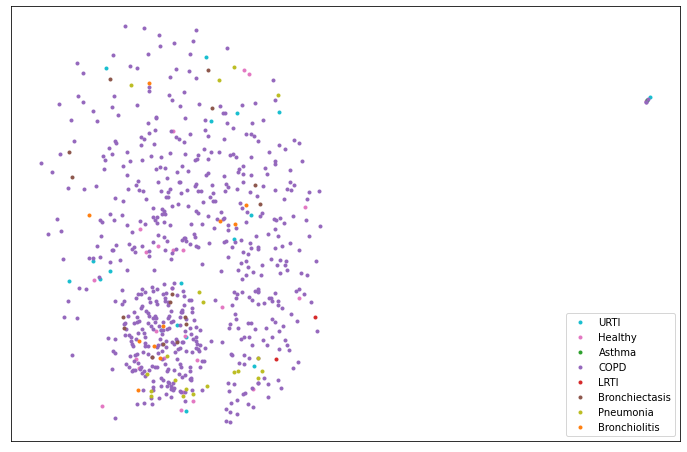

In [ ]:
plt.figure(figsize=(12,8))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(diagnoses == c)[0]
  plt.plot(embedding[q,0], embedding[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique());

In [ ]:
crackle_files = label_df.loc[(label_df['Crackles Only'] > 0) & (label_df['Crackles and Wheezes'] == 0) & (label_df['Wheezes Only'] == 0)]['Filename'].to_list()

crackle_diagnoses = []
for name in crackle_files:
  d = sub_anno_df.loc[sub_anno_df['Filename'] == name, 'Diagnosis'].unique()
  crackle_diagnoses.append(d[0])
crackle_diagnoses = np.array(crackle_diagnoses)

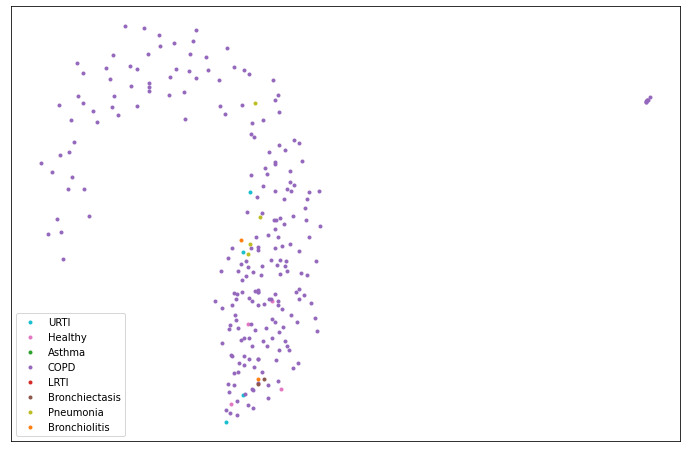

In [ ]:
plt.figure(figsize=(12,8))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(crackle_diagnoses == c)[0]
  plt.plot(embedding[q,0], embedding[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique());

In [ ]:
wheeze_files = label_df.loc[(label_df['Wheezes Only'] > 0) & (label_df['Crackles and Wheezes'] == 0) & (label_df['Crackles Only'] == 0)]['Filename'].to_list()

wheeze_diagnoses = []
for name in wheeze_files:
  d = sub_anno_df.loc[sub_anno_df['Filename'] == name, 'Diagnosis'].unique()
  wheeze_diagnoses.append(d[0])
wheeze_diagnoses = np.array(wheeze_diagnoses)

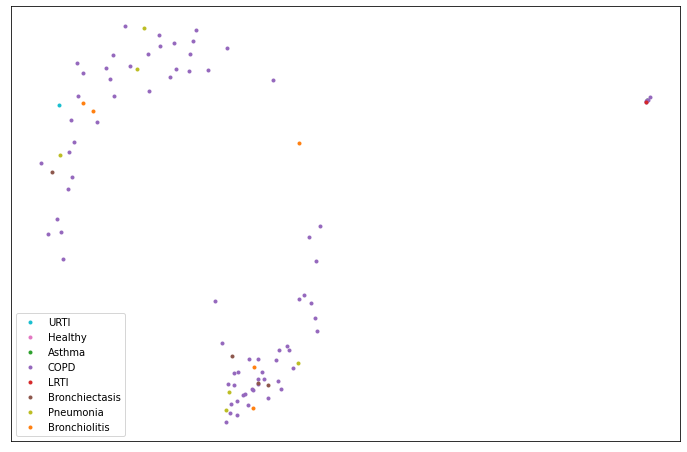

In [ ]:
plt.figure(figsize=(12,8))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(wheeze_diagnoses == c)[0]
  plt.plot(embedding[q,0], embedding[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique());

In [ ]:
cw_files = label_df.loc[(label_df['Crackles and Wheezes'] > 0) & (label_df['Crackles Only'] > 0) & (label_df['Wheezes Only'] > 0)]['Filename'].to_list()

cw_diagnoses = []
for name in cw_files:
  d = sub_anno_df.loc[sub_anno_df['Filename'] == name, 'Diagnosis'].unique()
  cw_diagnoses.append(d[0])
cw_diagnoses = np.array(cw_diagnoses)

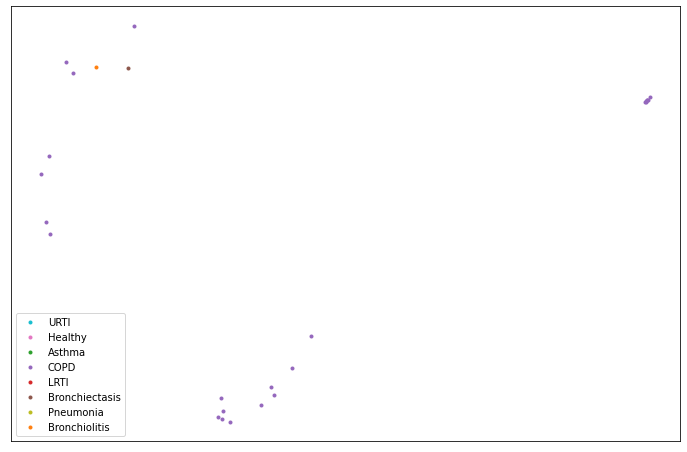

In [ ]:
plt.figure(figsize=(12,8))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(cw_diagnoses == c)[0]
  plt.plot(embedding[q,0], embedding[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique());

Audio Slicing

In [ ]:
def audio_dict_slice(wave_dict, timestamp_df):
  """
  segments the audio files contained in a waveform dictionary using timestamp annotations
  """
  slice_dict = {}
  for filename, signal in wave_dict.items():
    files = timestamp_df.loc[timestamp_df['Filename'] == filename]
    
    for i, row in files.iterrows():
      start = row['Start']
      end = row['End']
      audio_seg = slice_signal(start, end, signal)
      if (len(audio_seg) % 2) == 0: # signal array must be an even number of values for MODWT
        new_file = filename + "_" + str(i)
        slice_dict[new_file] = audio_seg
  return slice_dict

def slice_signal(start, end, signal, sr=4000):
  max_index = len(signal)
  start_index = min(int(start * sr), max_index)
  end_index = min(int(end * sr), max_index)
  return signal[start_index:end_index]

In [ ]:
if (('train_slices.pkl' in os.listdir('obj')) == False):
  train_slices = audio_dict_slice(train_waves, sub_anno_df)
  save_obj(train_slices, 'train_slices')
else:
  train_slices = load_obj('train_slices')

In [ ]:
if (('test_slices.pkl' in os.listdir('obj')) == False):
  test_slices = audio_dict_slice(test_waves, sub_anno_df)
  save_obj(test_slices, 'test_slices')
else:
  test_slices = load_obj('test_slices')

In [ ]:
if (('slices.mat' in os.listdir()) == False):
  train_slices = audio_dict_slice(train_waves, sub_anno_df)
  test_slices = audio_dict_slice(test_waves, sub_anno_df)
  spio.savemat( 'slices.mat', { 'train_slices': train_slices, 'test_slices': test_slices }  )
else:
  dat = spio.loadmat( 'slices.mat' )
  train_slices = dat['train_slices']
  test_slices = dat['test_slices']

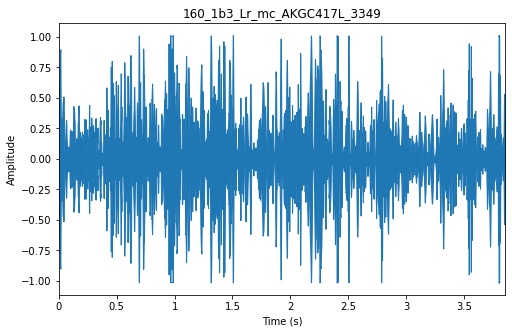

In [ ]:
plt.figure(figsize=(8,5))
lr.display.waveplot(train_slices['160_1b3_Lr_mc_AKGC417L_3349'], sr=4000)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('160_1b3_Lr_mc_AKGC417L_3349')
plt.show()

In [ ]:
Audio(train_slices['160_1b3_Lr_mc_AKGC417L_3349'], rate=4000)

In [ ]:
def slice_df(wave_dict, timestamp_df):
  """
  compiles the slice names and crackle/wheeze labels into one dataframe
  """
  names = []
  crackles = []
  wheezes = []
  for filename, signal in wave_dict.items():
    files = timestamp_df.loc[timestamp_df['Filename'] == filename]
    
    for i, row in files.iterrows():
      crackles.append(row['Crackles'])
      wheezes.append(row['Wheezes'])
      names.append(filename + "_" + str(i))
  return pd.DataFrame(data = {'Slice Name': names, 'Crackles': crackles, 'Wheezes': wheezes})

In [ ]:
train_slice_anno_df = slice_df(train_waves, sub_anno_df)
test_slice_anno_df = slice_df(test_waves, sub_anno_df)
slice_anno_df = pd.concat([train_slice_anno_df, test_slice_anno_df])
slice_anno_df.head()

In [ ]:
# Extract features from slices
def extract(filenames, root, timestamp_df, sr):
  """
  filenames: the names of audio (.wav) files (i.e. 185_1b1_Al_sc_Litt3200)
  root: main directory path
  timestamp_df: dataframe containing start and end times of segments in each file
  sr: sample rate
  """
  bbfs = [] # Butterworth Bandpass Filter
  spectrograms = []
  centroids = []
  mfccs = []
  modwts = []
  # scores = []

  # Get waveforms to segment into slices
  wave_dict = {}
  for name in filenames:
    (signal, sr) = signal_and_sr(name, root)
    wave_dict[name] = signal  

  slices_dict = audio_dict_slice(wave_dict, timestamp_df)
  signals = [*slices_dict.values()]

  # Apply bandpass filter
  bbf_signals = [] # Waveform signals are not all the same shape... can't initialize bbfs array without determining maximum columns?
  for i, signal in enumerate(signals):
    z = butter_bandpass_filter(signal, 120, 1800) 
    bbf_signals.append(z.shape[0])
  for i, signal in enumerate(signals):
    y = butter_bandpass_filter(signal, 120, 1800) 
    if i == 0:
      bbfs = np.zeros( (len(signals), max(bbf_signals)) )
    bbfs[i,:len(y)] = y

  # Get spectrograms
  for i, signal in enumerate(bbfs):
    stft = librosa.stft(signal)
    z = librosa.amplitude_to_db(abs(stft))[0]
    if i==0:
      spectrograms = np.zeros( (len(slices_dict.keys()), max(bbf_signals)) ) 
    spectrograms[i,:len(z)] = z

  # Get centroids
  for i, signal in enumerate(bbfs):
    z = librosa.feature.spectral_centroid(signal, sr=sr)[0]
    if i == 0:
      centroids = np.zeros((len(slices_dict.keys()), z.shape[0]))
    centroids[i,:len(z)] = z

  # Get MFCCs
  for i, signal in enumerate(bbfs):
    z = librosa.feature.mfcc(y=signal, sr=sr)[0]
    if i == 0:
      mfccs = np.zeros((len(slices_dict.keys()), z.shape[0]))
    mfccs[i,:len(z)] = z
  
  # Get MODWTs
  for i, signal in enumerate(bbfs):
    z = pywt.swt(signal, 'db5', level=2, trim_approx=True, norm=True)[1]
    if i == 0:
      modwts = np.zeros((len(slices_dict.keys()), z.shape[0]))
    modwts[i,:len(z)] = z

  return spectrograms, centroids, mfccs, modwts

start = tm.time()

if (('spectrograms.pkl' in os.listdir('obj')) == False):  
  
  # tip: rename variable to convey what it stands will help you especially if you have long break after before you return to your code months later

  spectrograms, centroids, mfccs, modwts = extract(filenames, root, sub_anno_df, 4000)
  # features = np.hstack([spectrograms, centroids, mfccs, modwts])

  # save_obj(features, 'slice_train_features_k4')
  #save_obj(spectrograms, outdir+'spectrograms')
  save_obj(centroids, outdir+'centroids')
  #save_obj(mfccs,outdir+ 'mfccs')
  #save_obj(modwts, outdir+'modwts')
  
else:
  # features = load_obj('slice_train_features_k4')
  spectrograms = load_obj('spectrograms')
  centroids = load_obj('centroids')
  mfccs = load_obj('mfccs')
  modwts = load_obj('modwts')

# task3: timing info would be nice
end = tm.time()
print(f"Runtime to extract is {end-start} s")

Feature UMAPs (All Slices)

In [ ]:
z = librosa.feature.spectral_centroid(signal, sr=sr)[0]


NameError: ignored

In [ ]:
um = umap.UMAP(random_state=123)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


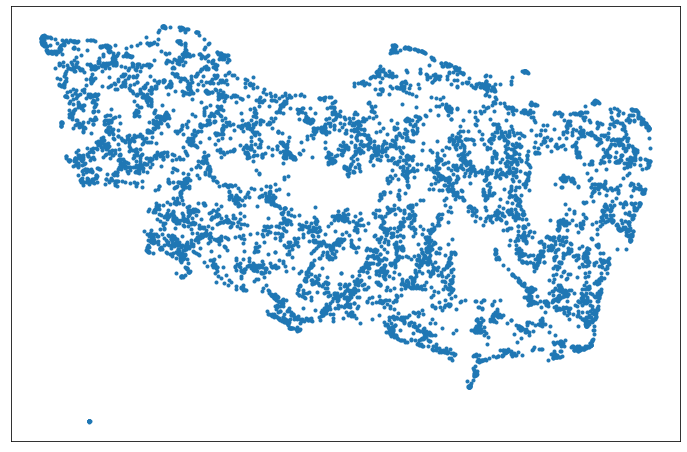

In [ ]:
mfcc_umap = um.fit_transform(mfccs)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.plot(mfcc_umap[:,0], mfcc_umap[:,1], '.')
plt.xticks([]), plt.yticks([]);

In [ ]:
mfcc_umap = um.fit_transform(mfccs)

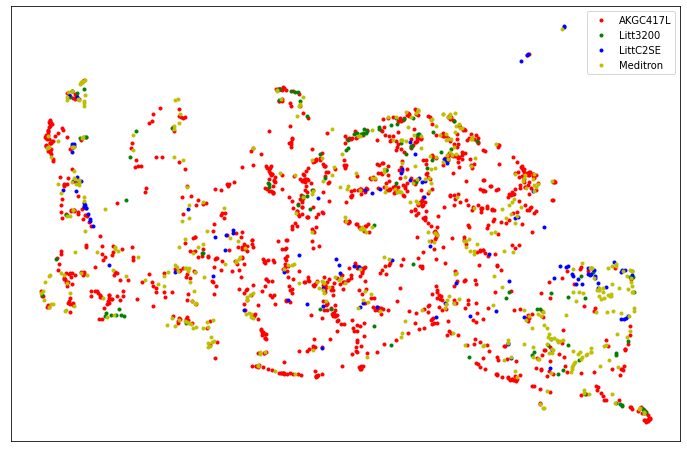

In [ ]:
plt.figure(figsize=(12,8))
for i, c in enumerate(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']):
  q = np.where(equipment == c)[0]
  plt.plot(mfcc_umap[q,0], mfcc_umap[q,1], '.', color=clrs[i])
plt.xticks([]),plt.yticks([])
plt.legend(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']);

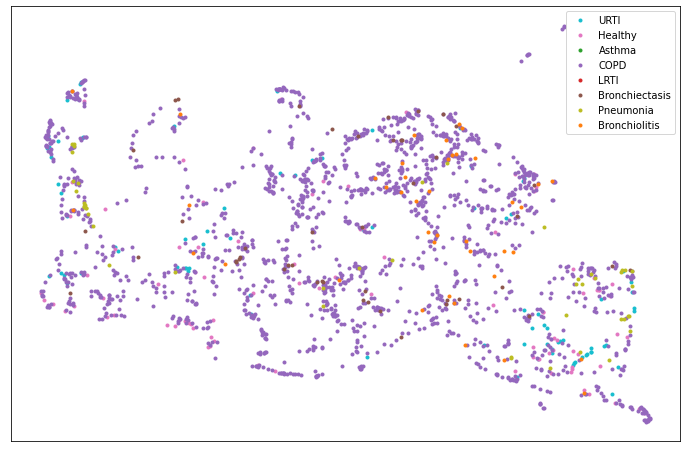

In [ ]:
plt.figure(figsize=(12,8))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(diagnoses == c)[0]
  plt.plot(mfcc_umap[q,0], mfcc_umap[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique());

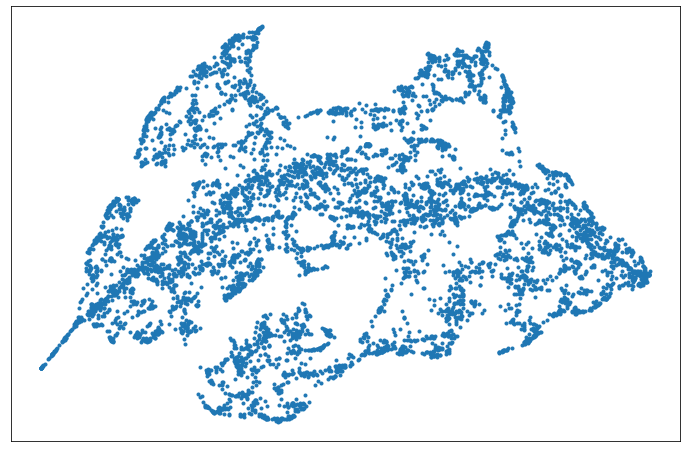

In [ ]:
spec_umap = um.fit_transform(spectrograms)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.plot(spec_umap[:,0], spec_umap[:,1], '.')
plt.xticks([]), plt.yticks([]);

In [ ]:
spec_umap = um.fit_transform(spectrograms)

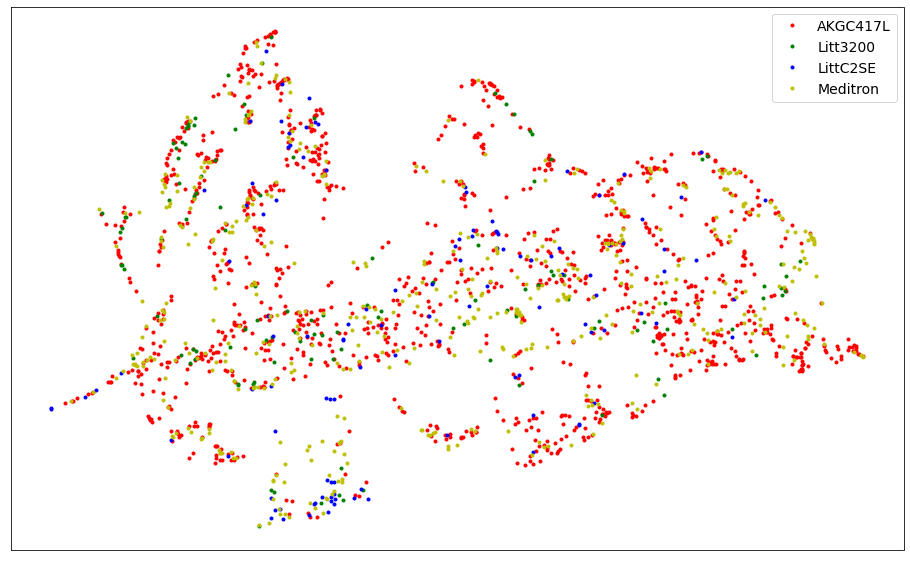

In [ ]:
plt.figure(figsize=(16,10))
for i, c in enumerate(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']):
  q = np.where(equipment == c)[0]
  plt.plot(spec_umap[q,0], spec_umap[q,1], '.', color=clrs[i])
plt.xticks([]),plt.yticks([])
plt.legend(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron'], prop={'size': 14});

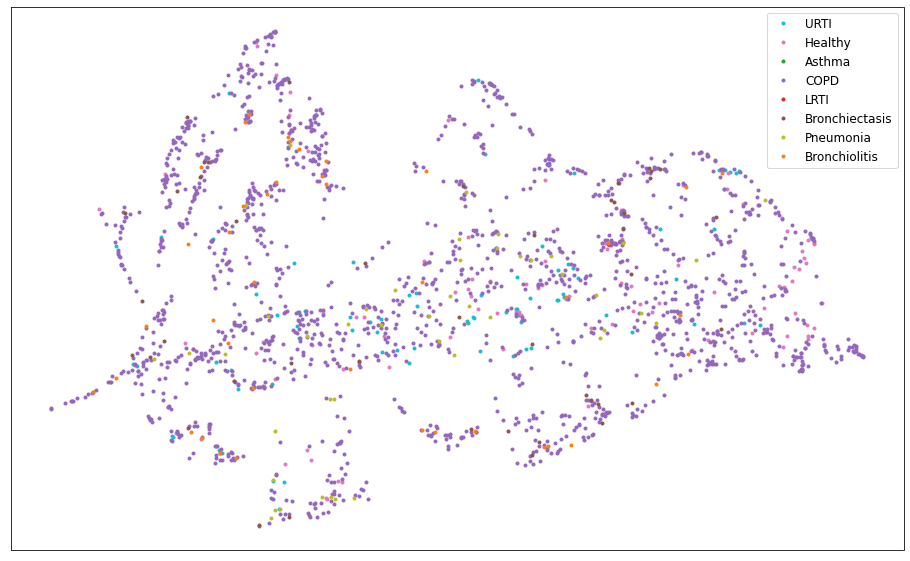

In [ ]:
plt.figure(figsize=(16,10))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(diagnoses == c)[0]
  plt.plot(spec_umap[q,0], spec_umap[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique(), prop={'size': 12});

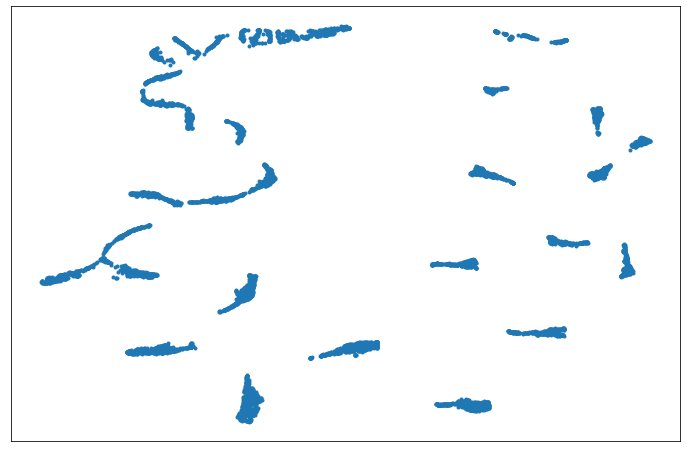

In [ ]:
cent_umap = um.fit_transform(centroids)
fig, ax = plt.subplots(1, figsize=(12,8))
plt.plot(cent_umap[:,0], cent_umap[:,1], '.')
plt.xticks([]), plt.yticks([]);

In [ ]:
cent_umap = um.fit_transform(centroids)

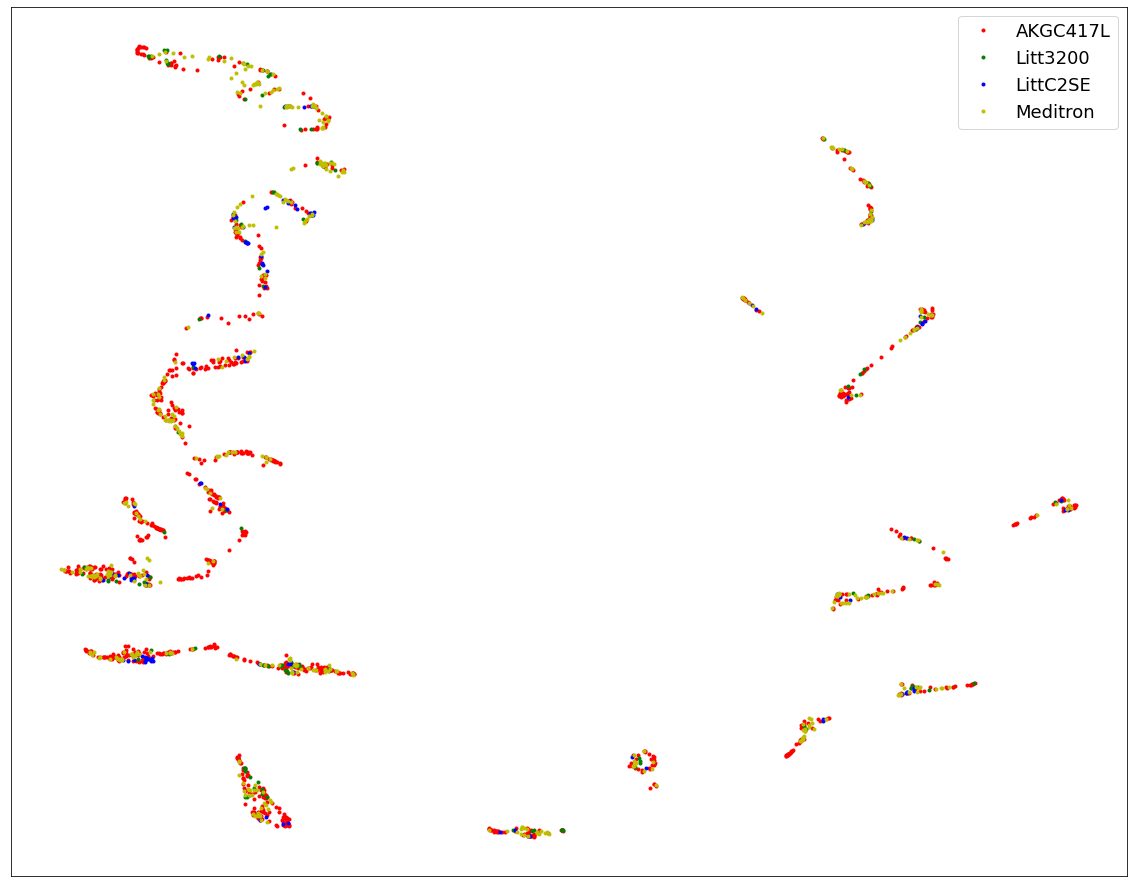

In [ ]:
plt.figure(figsize=(20,16))
for i, c in enumerate(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']):
  q = np.where(equipment == c)[0]
  plt.plot(cent_umap[q,0], cent_umap[q,1], '.', color=clrs[i])
plt.xticks([]),plt.yticks([])
plt.legend(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron'], prop={'size': 18});

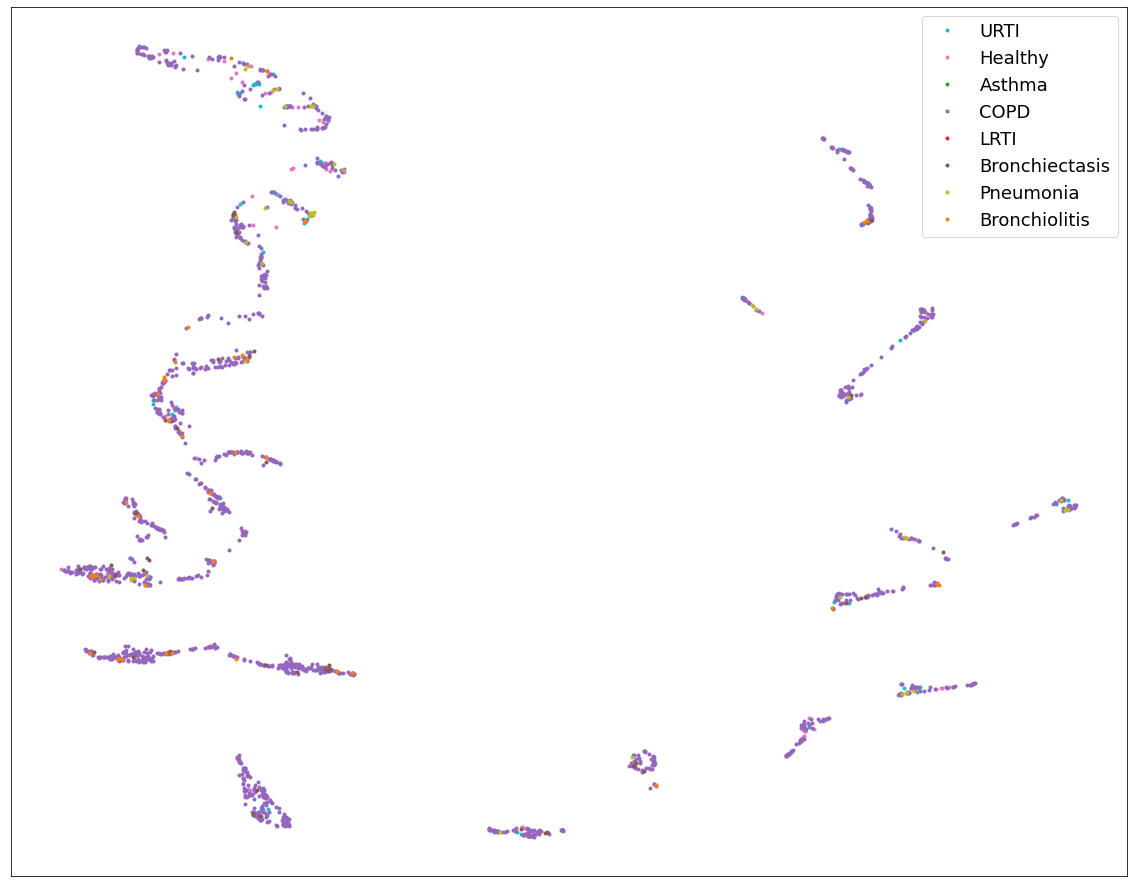

In [ ]:
plt.figure(figsize=(20,16))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(diagnoses == c)[0]
  plt.plot(cent_umap[q,0], cent_umap[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique(), prop={'size': 18});

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


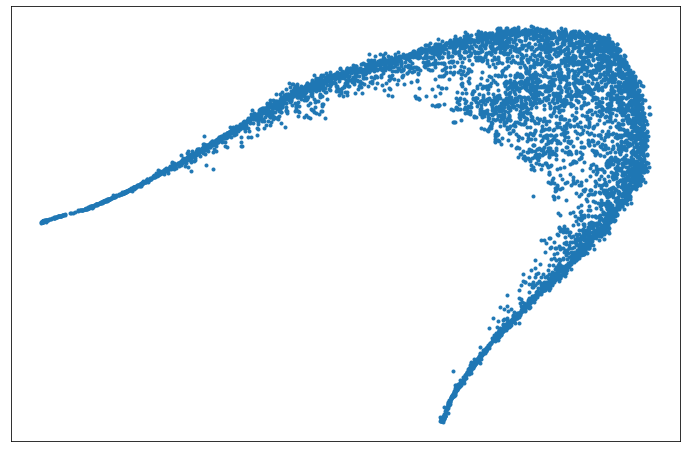

In [ ]:
modwt_umap = um.fit_transform(modwts[:,::100])
fig, ax = plt.subplots(1, figsize=(12,8))
plt.plot(modwt_umap[:,0], modwt_umap[:,1], '.')
plt.xticks([]), plt.yticks([]);

In [ ]:
modwt_umap = um.fit_transform(modwts)

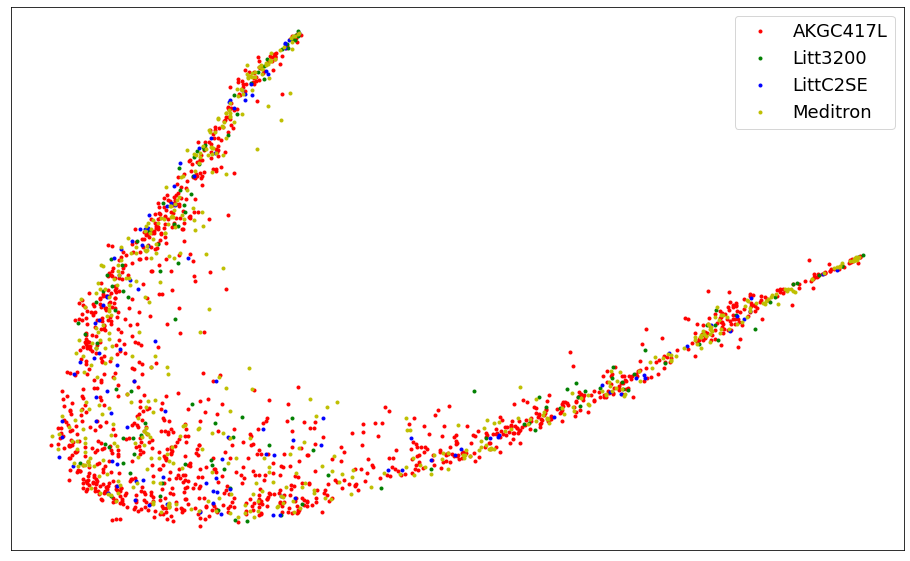

In [ ]:
plt.figure(figsize=(16,10))
for i, c in enumerate(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']):
  q = np.where(equipment == c)[0]
  plt.plot(modwt_umap[q,0], modwt_umap[q,1], '.', color=clrs[i])
plt.xticks([]),plt.yticks([])
plt.legend(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron'], prop={'size': 18});

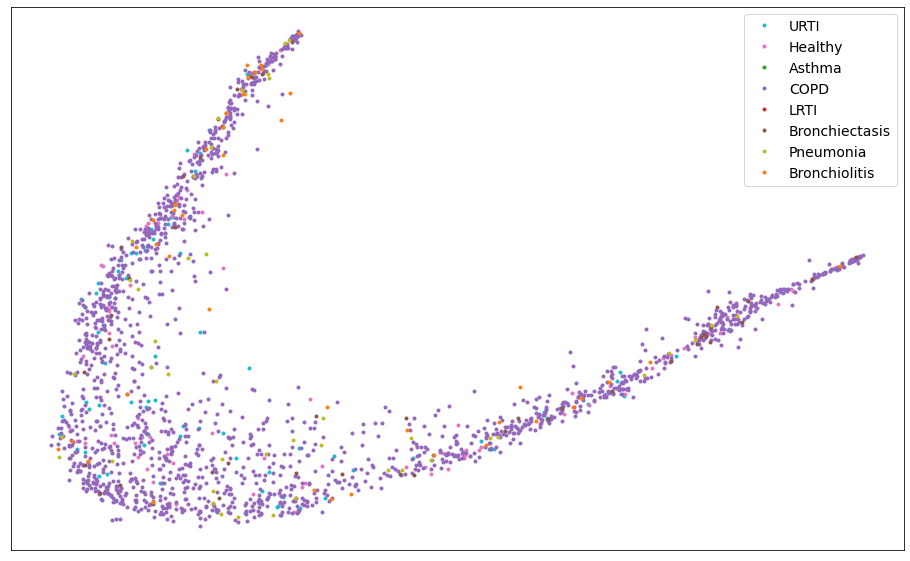

In [ ]:
plt.figure(figsize=(16,10))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(diagnoses == c)[0]
  plt.plot(modwt_umap[q,0], modwt_umap[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique(), prop={'size': 14});

Crackles & Wheezes

In [ ]:
def graph_sounds(filename, wave_dict, timestamp_df):
  df = timestamp_df.loc[timestamp_df['Filename'] == filename]
  signal = wave_dict[filename]

  crackles = df.loc[df['Crackles'] >= 1]
  crackle_times = crackles[['Start', 'End']]
  wheezes = df.loc[df['Wheezes'] >= 1]
  wheeze_times = wheezes[['Start', 'End']]

  plt.figure(figsize=(8,5))
  lr.display.waveplot(signal, sr=4000, color='g')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.title(filename)

  if len(crackle_times) != 0:
    for i, row in crackle_times.iterrows():
      plt.axvspan(row[0], row[1], alpha=0.2, color='red')
  
  if len(wheeze_times) != 0:
    for i, row in wheeze_times.iterrows():
      plt.axvspan(row[0], row[1], alpha=0.2, color='blue')
  
  cr = mpatches.Patch(color='red', alpha=0.2, label='Crackle')
  wh = mpatches.Patch(color='blue', alpha=0.2, label='Wheeze')

  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', handles=[cr, wh])

  return plt.show()

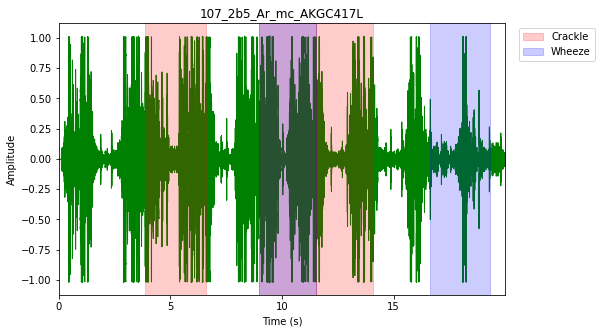

In [ ]:
graph_sounds('107_2b5_Ar_mc_AKGC417L', train_waves, sub_anno_df)

In [ ]:
a = sub_anno_df.loc[(sub_anno_df['Crackles'] >= 1) & (sub_anno_df['Wheezes'] >= 1)]
a

In [ ]:
label_df.loc[(label_df['Crackles Only'] >= 1) & (label_df['Wheezes Only'] >= 1) & (label_df['Crackles and Wheezes'] >= 1)]

Combined UMAP Models (Downsampled Slices)

In [ ]:
features.shape

(3959, 129558)

In [ ]:
um = umap.UMAP(random_state=123)
mfcc_umap = um.fit_transform(mfccs)
spec_umap = um.fit_transform(spectrograms)
cent_umap = um.fit_transform(centroids)
modwt_umap = um.fit_transform(modwts)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
intersection_mapper = mfcc_umap * spec_umap * cent_umap * modwt_umap
union_mapper = mfcc_umap + spec_umap + cent_umap + modwt_umap

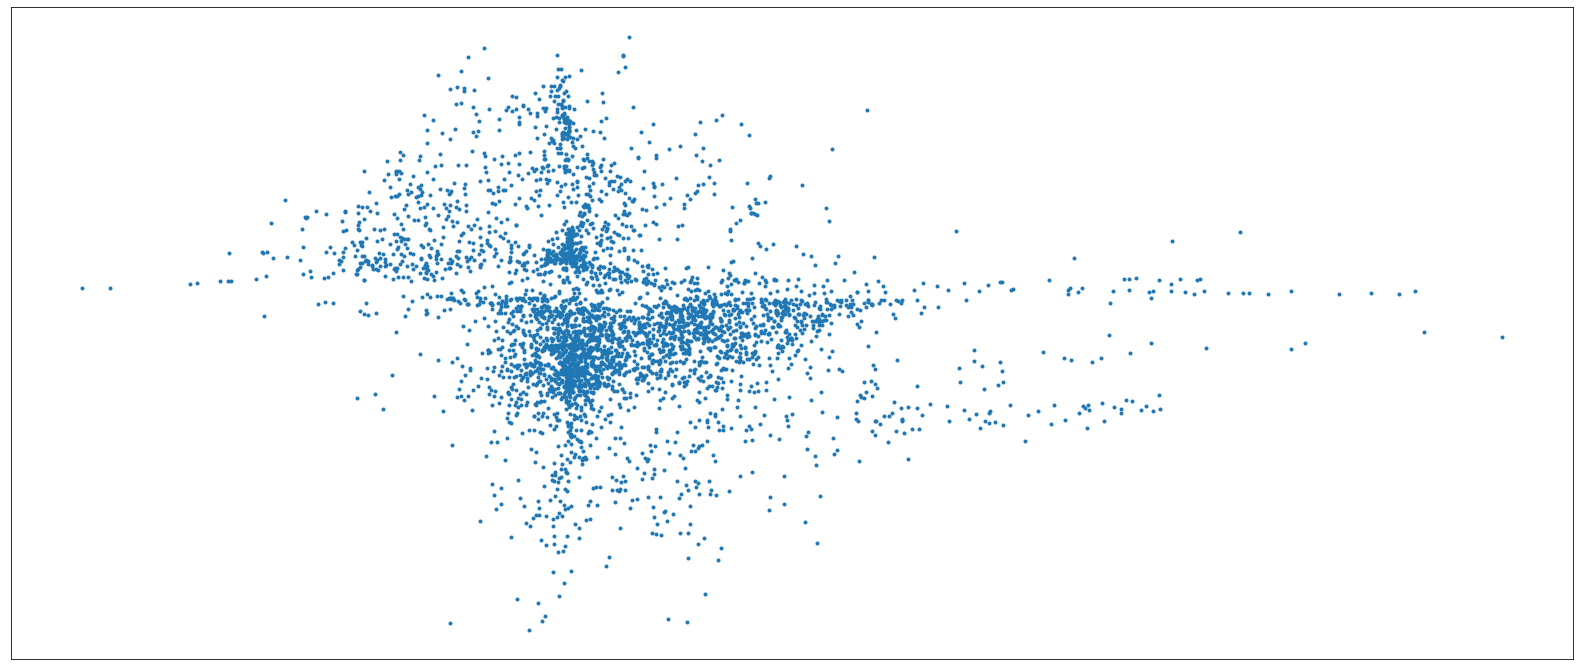

In [ ]:
fig, ax = plt.subplots(1, figsize=(28,12))
plt.plot(intersection_mapper[:,0], intersection_mapper[:,1], '.')
plt.xticks([]), plt.yticks([]);

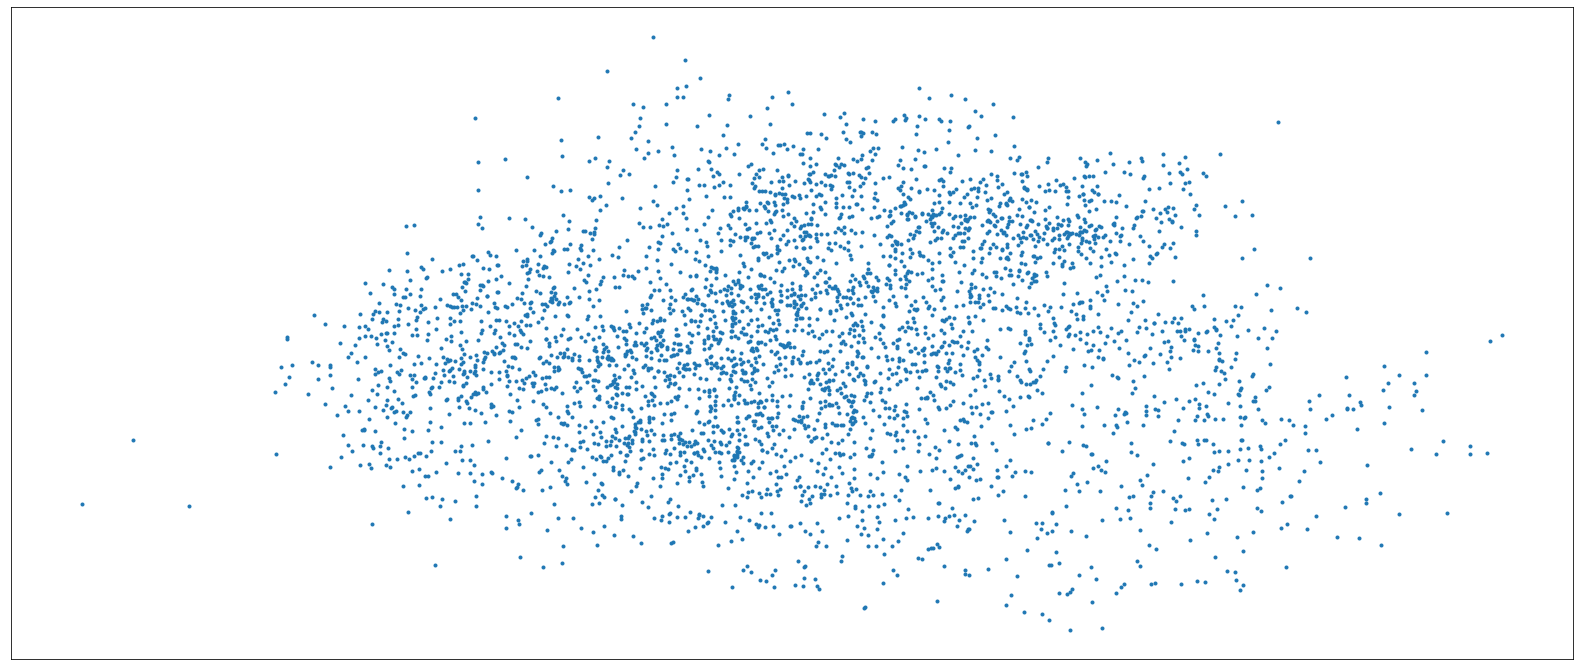

In [ ]:
fig, ax = plt.subplots(1, figsize=(28,12))
plt.plot(union_mapper[:,0], union_mapper[:,1], '.')
plt.xticks([]), plt.yticks([]);

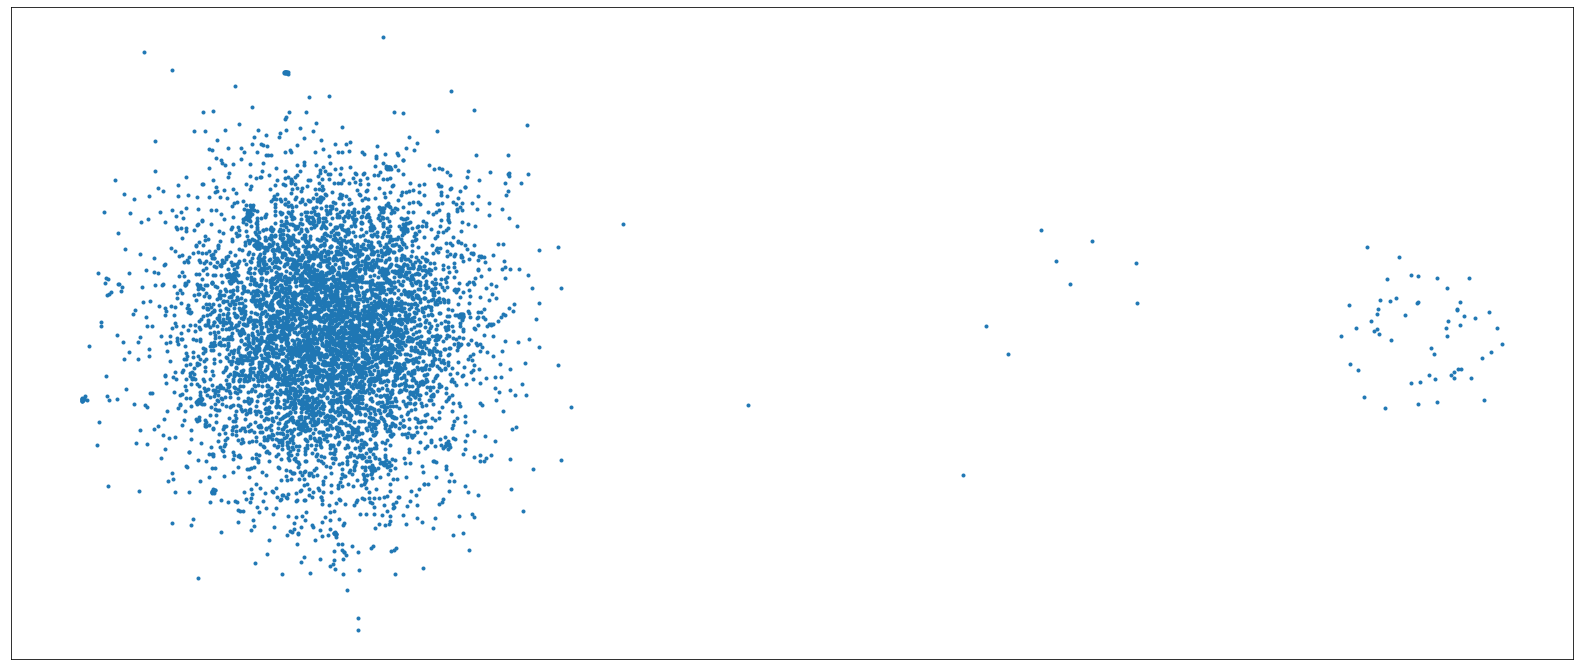

In [ ]:
# graphed using a larger subset of slices; filtering out files with uneven signals before segmenting
fig, ax = plt.subplots(1, figsize=(28,12))
plt.plot(union_mapper[:,0], union_mapper[:,1], '.')
plt.xticks([]), plt.yticks([]);

In [ ]:
filename_sample = filenames
waves = {}
for name in filename_sample:
    (signal, sr) = signal_and_sr(name, root)
    waves[name] = signal  
slices_dict = audio_dict_slice(waves, sub_anno_df)
slicenames = [*slices_dict.keys()]

In [ ]:
equipment = []
for name in slicenames:
  equipment.append(name.split('_')[4])
equipment = np.array(equipment)

clrs = ['r', 'g', 'b', 'y']

np.unique(equipment)

array(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron'], dtype='<U8')

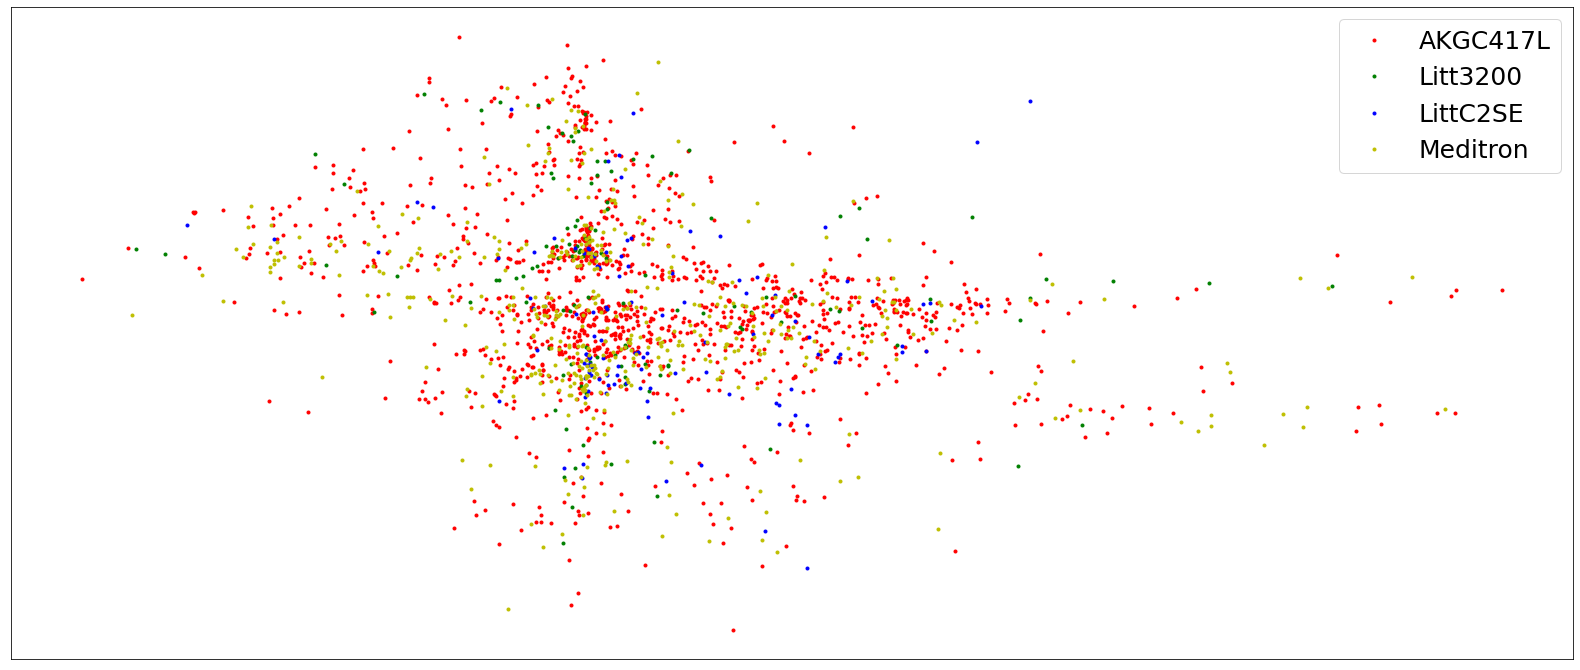

In [ ]:
plt.figure(figsize=(28,12))
for i, c in enumerate(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']):
  q = np.where(equipment == c)[0]
  plt.plot(intersection_mapper[q,0], intersection_mapper[q,1], '.', color=clrs[i])
plt.xticks([]),plt.yticks([])
plt.legend(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron'], prop={'size': 25});

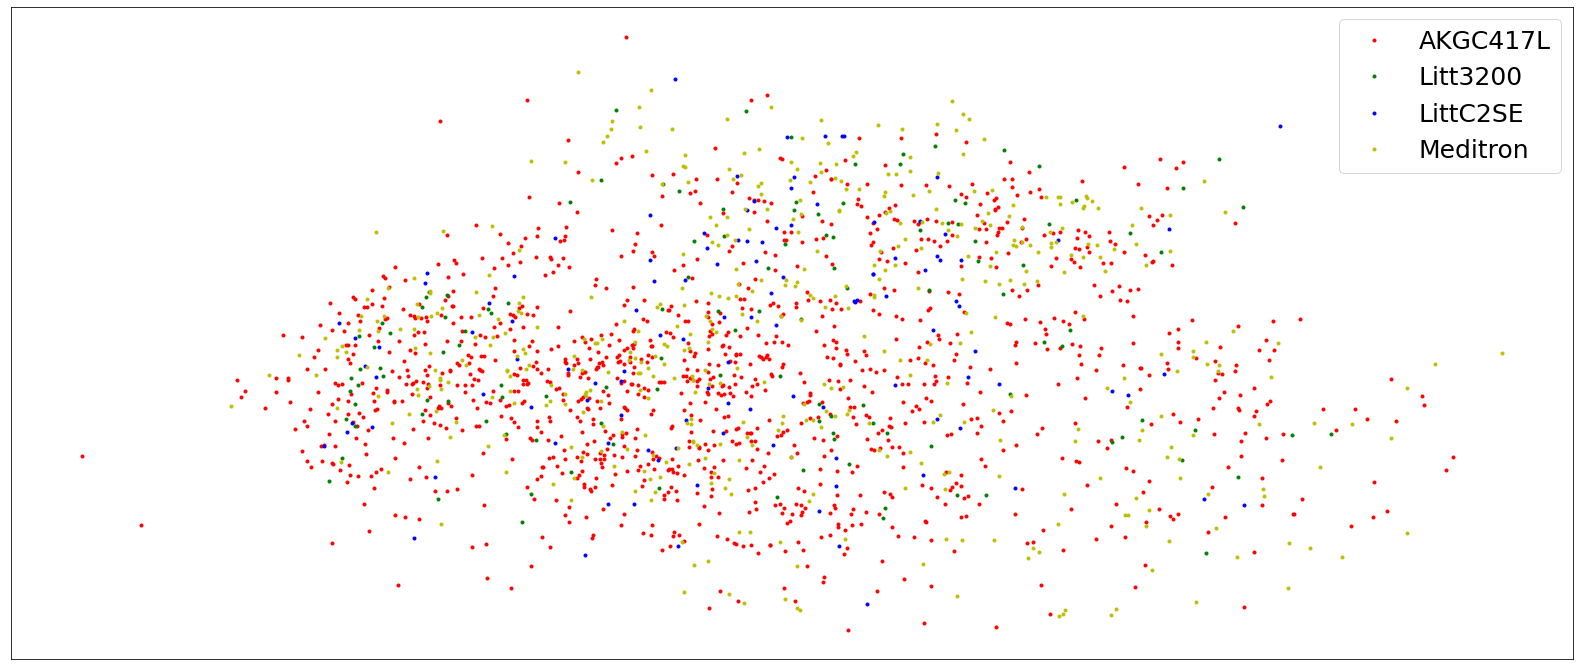

In [ ]:
plt.figure(figsize=(28,12))
for i, c in enumerate(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron']):
  q = np.where(equipment == c)[0]
  plt.plot(union_mapper[q,0], union_mapper[q,1], '.', color=clrs[i])
plt.xticks([]),plt.yticks([])
plt.legend(['AKGC417L', 'Litt3200', 'LittC2SE', 'Meditron'], prop={'size': 25});

In [ ]:
diagnoses = []
for name in slicenames:
  subID = int(name.split('_')[0])
  d = diag_df.loc[diag_df['Subject ID'] == subID, 'Diagnosis']
  diagnoses.append(d.to_list()[0])
diagnoses = np.array(diagnoses)

clrs2 = ['tab:cyan', 'tab:pink', 'tab:green', 'tab:purple', 'tab:red',
         'tab:brown', 'tab:olive', 'tab:orange']

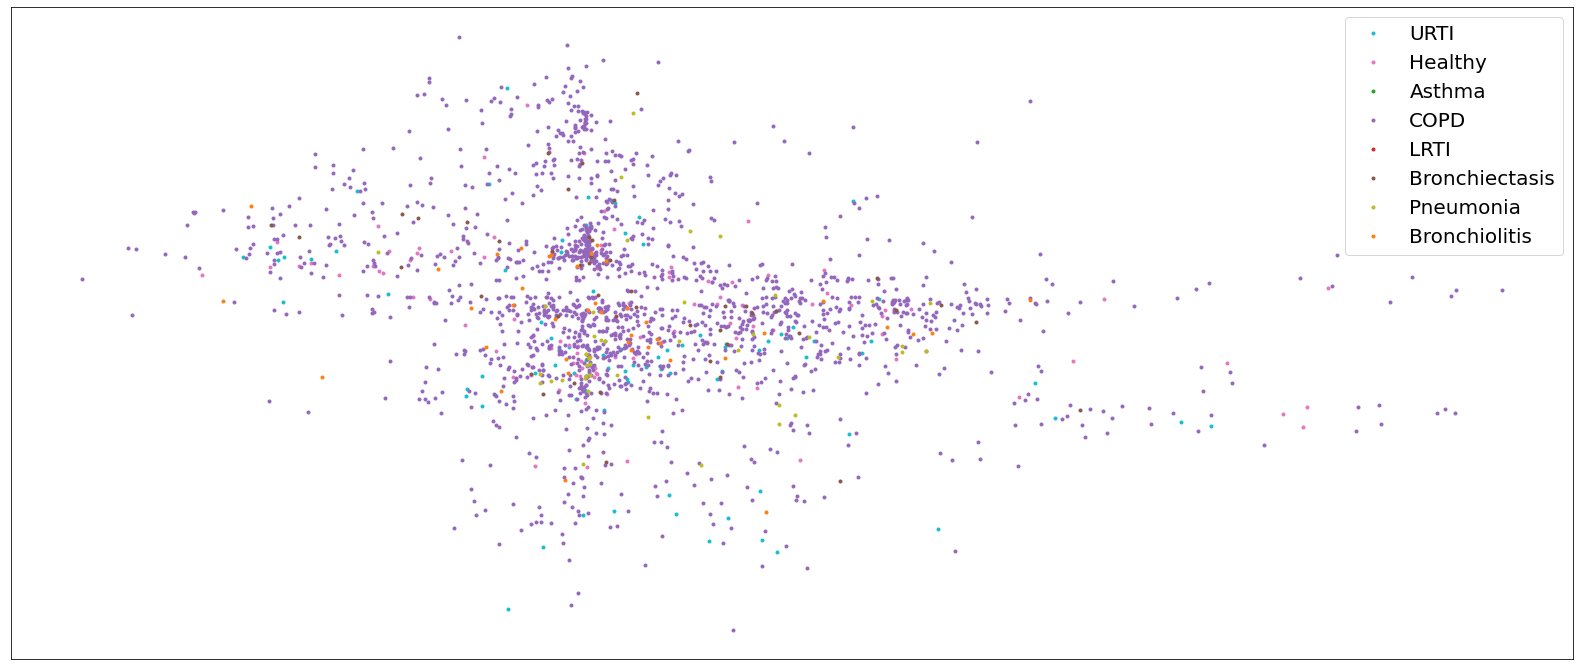

In [ ]:
plt.figure(figsize=(28,12))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(diagnoses == c)[0]
  plt.plot(intersection_mapper[q,0], intersection_mapper[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique(), prop={'size': 20});

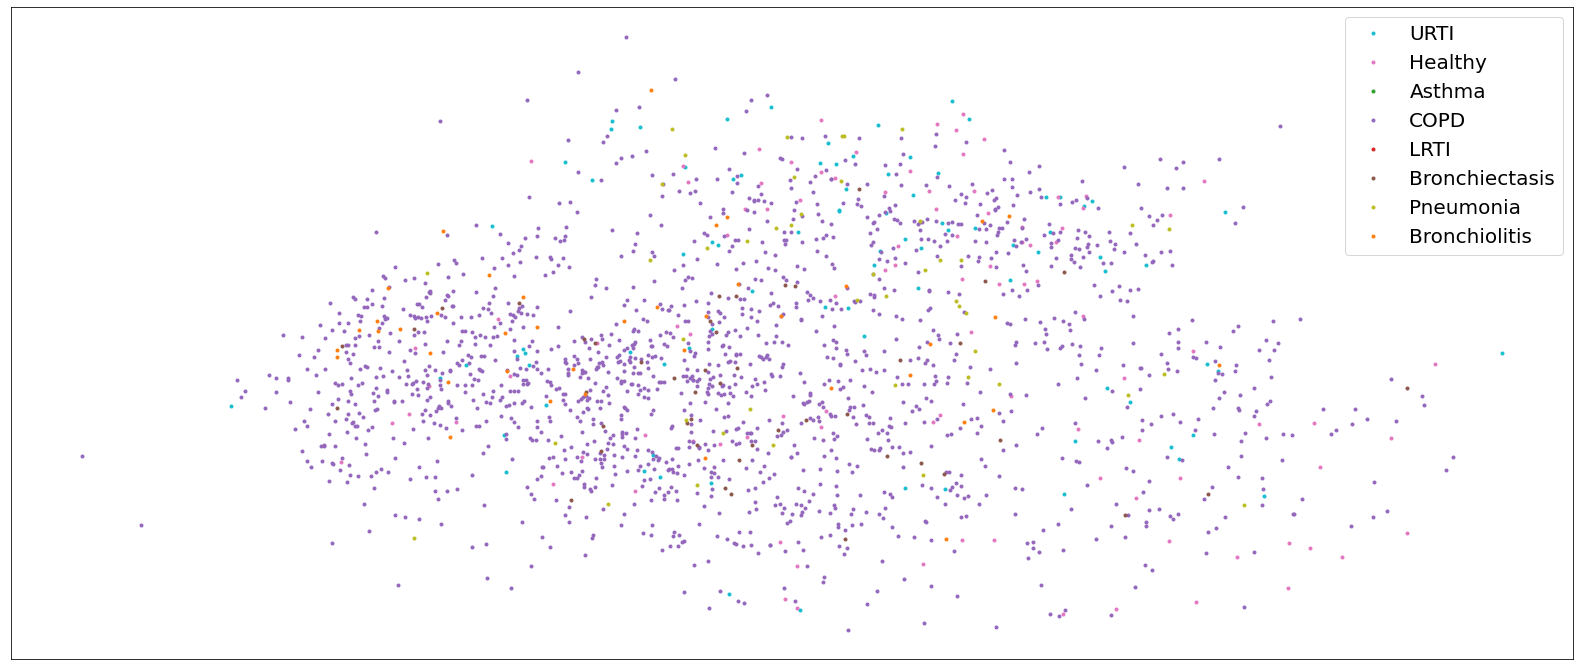

In [ ]:
plt.figure(figsize=(28,12))
for i, c in enumerate(diag_df['Diagnosis'].unique()):
  q = np.where(diagnoses == c)[0]
  plt.plot(union_mapper[q,0], union_mapper[q,1], '.', color=clrs2[i])
plt.xticks([]),plt.yticks([])
plt.legend(diag_df['Diagnosis'].unique(), prop={'size': 20});

Silhouette Plots (KMeans)

In [ ]:
features = np.hstack([mfccs, spectrograms, centroids, modwts])
features.shape

(3959, 129558)

In [ ]:
features[0]

array([-3.40730485e+02, -3.86172807e+02, -4.76906597e+02, ...,
        1.33796583e-02,  7.60327736e-03, -4.31309917e-03])

In [ ]:
def silhouette_plots(X, params=None):

  # Define number of clusters 
  if params is None:
    params = [{"n_clusters" : n} for n in range(2,6)]
  
  # Run KMeans algorithm
  clusterers = [KMeans(**p).fit(X) for p in params]

  for nn, clusterer in enumerate(clusterers):
    n_clusters = np.max(clusterer.labels_) + 1

    fig, ax = plt.subplots(1, 1)

    fig.set_size_inches(18, 7)

    # Insert blank space between silhouette plots of individual clusters
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    cluster_labels = clusterer.labels_

    # Average value for all samples; tells us about density & separation of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For n_clusters =', n_clusters, 'The average silhouette_score is :', silhouette_avg)

    # Compute silhouette scores
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):

      # Aggregate silhouette scores for samples belonging to cluster i
      ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == 1]
      
      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      colour = cm.nipy_spectral(float(i) / n_clusters)
      ax.fill_betweenx(np.arange(y_lower, y_upper),
                       0, ith_cluster_silhouette_values,
                       facecolor=colour, edgecolor=colour, alpha=0.7)
      
      # Label silhouette plots with cluster numbers
      ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      # Compute y_lower for next plot
      y_lower = y_upper + 10

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel('The silhouette coefficient values')
    ax.set_ylabel('Cluster label')

    # Vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    # ax.set_xticks([])

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5112626746906828


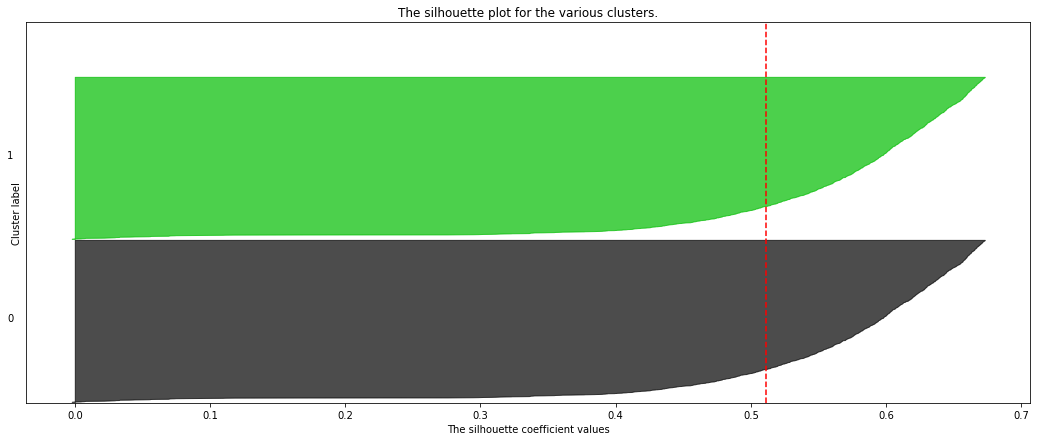

For n_clusters = 3 The average silhouette_score is : 0.41570209248759166


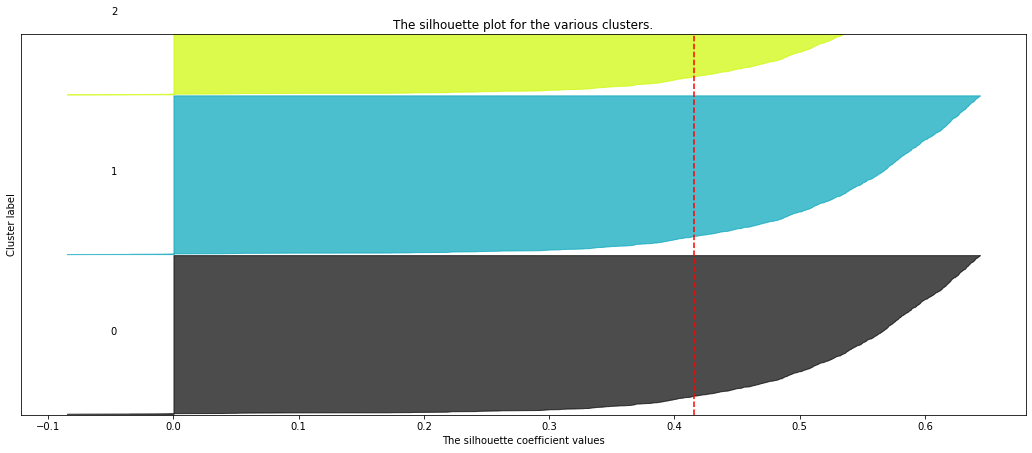

For n_clusters = 4 The average silhouette_score is : 0.3667835007331659


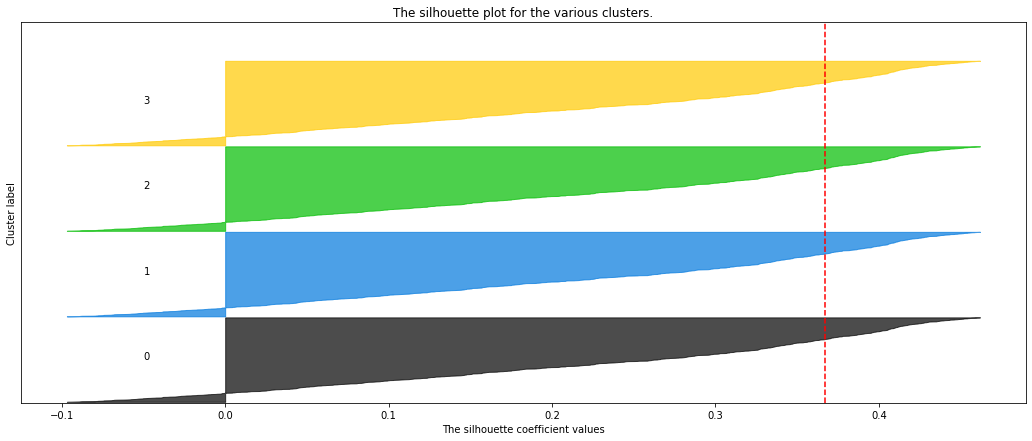

For n_clusters = 5 The average silhouette_score is : 0.3606195892419208


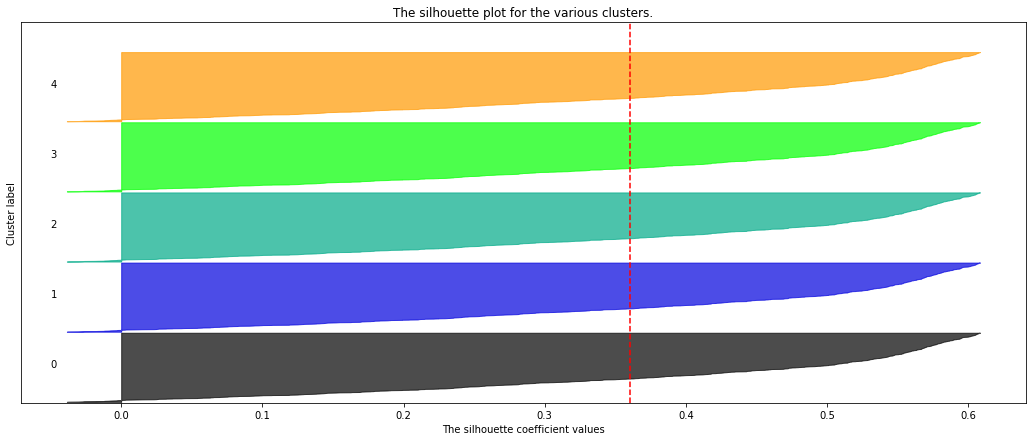

In [ ]:
silhouette_plots(features[:,::100])

K-Neighbours Classifier

In [ ]:
def extract_classes(filenames, root, anno_df):
  wave_dict = {}
  for name in filenames:
    (signal, sr) = signal_and_sr(name, root)
    wave_dict[name] = signal

  slices_dict = audio_dict_slice(wave_dict, anno_df)
  slice_anno_df = slice_df(wave_dict, anno_df)

  slices = [*slices_dict.keys()]

  slices_df = slice_anno_df.loc[slice_anno_df['Slice Name'].isin(slices)]

  crackles = slices_df.to_numpy()[:,1]
  wheezes = slices_df.to_numpy()[:,2]

  classes = np.zeros(len(crackles))

  for i, v in enumerate(crackles):
    if (crackles[i] == 0) & (wheezes[i] == 0):
      classes[i] = 0
    elif (crackles[i] > 0) & (wheezes[i] == 0):
      classes[i] = 1
    elif (crackles[i] == 0) & (wheezes[i] > 0):
      classes[i] = 2
    else:
      classes[i] = 3

  return classes

In [ ]:
classes = extract_classes(filenames, root, sub_anno_df)
classes

array([0., 0., 0., ..., 0., 1., 0.])

In [ ]:
# Feature arrays are different lengths which cannot be accepted by KNN ... approximating mean for each feature
mean_mfccs = []
mean_specs = []
mean_cents = []
mean_modwts = []

for i, mat in enumerate(mfccs):
  mean_mfccs.append(np.mean(mat))
for i, mat in enumerate(spectrograms):
  mean_specs.append(np.mean(mat))
for i, mat in enumerate(centroids):
  mean_cents.append(np.mean(mat))
for i, mat in enumerate(modwts):
  mean_modwts.append(np.mean(mat))

In [ ]:
#tester = [[2,39]]

# features.shape

mfccs



AttributeError: ignored

In [ ]:
feature_set = np.hstack([mean_mfccs, mean_specs, mean_cents, mean_modwts])

# feature_set = []
# for i, values in enumerate(mfccs): 
#   feature_set.append([mfccs[i], spectrograms[i], centroids[i], modwts[i]])
# feature_set

In [ ]:
knc_model = KNeighborsClassifier(n_neighbors=8)
knc_model.fit(features, classes)

ValueError: ignored

In [ ]:
label_pred = knc_model.predict()